In [21]:
import torch
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import pickle
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from torchvision import models
from torchsummary import summary
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpu_id = [0] # only modify if you machine has more than one GPU card

In [6]:
import h5py
import os
import glob
import torch
import numpy as np
import pandas as pd
from skimage import io, transform
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split


normalize = transforms.Normalize((0.5)*34, (0.5)*34)
VALIDATION_SPLIT = 0.05

SPECIM = '/ibex/scratch/projects/c2064/data/hyperspectral/'

class RandomHorizontalFlip():
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def __call__(self, sample):
        x = sample['image']
        y = sample['label']
        if np.random.rand(1) < self.prob:
            sample['image'] = torch.flip(x,dims=(-1,))
            sample['label'] = torch.flip(y,dims=(-1,))
        return sample
    
class ImageNormalize(object):
    def __call__(self, sample):
        x = sample['image']
        sample['image'] = normalize(x)
        return sample
    
class Clamp():
    def __call__(self, sample):
        x = sample['image']
        sample['image'] = torch.clamp(sample['image'],0.0,1.0)
        return sample
    
class RandomHorizontalFlip():
    def __init__(self, prob=0.5):
        self.prob = prob
    
    def __call__(self, sample):
        x = sample['image']
        y = sample['label']
        if np.random.rand(1) < self.prob:
            sample['image'] = torch.flip(x,dims=(-1,))
            sample['label'] = torch.flip(y,dims=(-1,))
            if 'rgb' in sample:
                sample['rgb'] = torch.flip(sample['rgb'],dims=(-1,))
        return sample

    
class SegIdentityTransform(object):
    # Hint: Note that our transforms work on dicts. This is an example of a transform that works
    # on a dict whose elements can be converted to np.arrays, and are then converted to torch.tensors
    # This performs the scaling of the RGB by division by 255, and puts channels first by performing the permute
    # for the label, we convert to long, datatype to let torch know that this is a discrete label.
    # You might want to change this or write different transforms depending on how you read data.
    def __call__(self, sample):
        output = {'image': torch.tensor(np.array(sample['image'])).permute(2,0,1),
                'label': torch.tensor(np.array(sample['label'])).long()}
        if 'rgb' in sample:
            output['rgb'] = torch.tensor(np.array(sample['rgb'])).permute(2,0,1)
        return output
    
class RandomCrop():
    def __init__(self, target_size=(256,256), edge=10):
        self.target_size = target_size
        self.edge = edge
    def __call__(self, sample):
        if min(sample['label'].shape) < max(self.target_size) + 2*self.edge:
            sample = Resize(self.target_size)(sample)
            return sample
        wx, wy = self.target_size
        wx0 , wy0 = sample['label'].shape
        try:
            center_x = np.random.randint(self.edge+wx//2,wx0 - self.edge - wx//2)
            center_y = np.random.randint(self.edge+wy//2,wy0 - self.edge - wy//2)
        except:
            print(sample['label'].shape)
        crop_x_0 = center_x - wx // 2
        crop_x_1 = center_x + wx // 2
        crop_y_0 = center_y - wy // 2
        crop_y_1 = center_y + wy // 2
        sample['image'] = sample['image'][crop_x_0:crop_x_1,crop_y_0:crop_y_1].astype(float)
        sample['label'] = sample['label'][crop_x_0:crop_x_1,crop_y_0:crop_y_1].astype(int)
        return sample
    
class RandomCropHoriz():
    def __init__(self, target_size=(256,256), edge=10, shift=170):
        self.target_size = target_size
        self.edge = edge
        self.shift = shift
    def __call__(self, sample):
        if min(sample['label'].shape) < max(self.target_size) + 2*self.edge:
            sample = Resize(self.target_size)(sample)
            return sample
        wx, wy = self.target_size
        wx0 , wy0 = sample['label'].shape
        try:
            center_x = np.random.randint(self.edge+wx//2,wx0 - self.edge - wx//2)
            center_y = np.random.randint(self.edge+wy//2,wy0 - self.edge - wy//2)
        except:
            print(sample['label'].shape)
        crop_x_0 = center_x - wx // 2
        crop_x_1 = center_x + wx // 2
        crop_y_0 = center_y - wy // 2
        crop_y_1 = center_y + wy // 2
        sample['image'] = sample['image'][self.shift:self.shift+self.target_size[0],crop_y_0:crop_y_1].astype(float)
        sample['label'] = sample['label'][self.shift:self.shift+self.target_size[0],crop_y_0:crop_y_1].astype(int)
        if 'rgb' in sample:
            sample['rgb'] = sample['rgb'][self.shift:self.shift+self.target_size[0],crop_y_0:crop_y_1].astype(float)
        return sample
    
class_names = ['bg,',
                    'real potato',
                    'fake potato',
                    'real apple',
                    'fake apple',
                    'real orange',
                    'fake orange',
                    'real grape',
                    'fake grape',
                    'real lemons',
                    'fake lemons',
                    'real avocado',
                    'fake avocado',
                    'real pepper',
                    'fake pepper',
                    'real unknown',
                    'fake unknown']

def get_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray([[0, 0, 0],
                       [128, 0, 0],
                       [0, 128, 0],
                       [128, 128, 0],
                       [0, 0, 128],
                       [128, 0, 128],
                       [0, 128, 128],
                       [128, 128, 128],
                       [64, 0, 0],
                       [192, 0, 0],
                       [64, 128, 0],
                       [192, 128, 0],
                       [64, 0, 128],
                       [192, 0, 128],
                       [64, 128, 128],
                       [192, 128, 128],
                       [0, 64, 0],
                       [128, 64, 0],
                       [0, 192, 0],
                       [128, 192, 0],
                       [0, 64, 128]])

def encode_segmap(mask):
    """Encode segmentation label images as pascal classes
    Args:
        mask (np.ndarray): raw segmentation label image of dimension
          (M, N, 3), in which the Pascal classes are encoded as colours.
    Returns:
        (np.ndarray): class map with dimensions (M,N), where the value at
        a given location is the integer denoting the class index.
    """

    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)
    for i, label in enumerate(get_labels()):
        label_mask[np.where(np.all(mask==label, axis=-1))[:2]] = i
    return label_mask

def decode_segmap(mask, unk_label=255):
    """Decode segmentation label prediction as RGB images
    Args:
        mask (torch.tensor): class map with dimensions (B, M,N), where the value at
        a given location is the integer denoting the class index.
    Returns:
        (np.ndarray): colored image of shape (BM, BN, 3)
    """
    mask[mask == unk_label] == 0
    mask = mask.numpy()
    cmap = get_labels()
    cmap_exp = cmap[..., None]
    colored = cmap[mask].squeeze()
    grid = make_grid(torch.tensor(colored).permute(0, 3, 1, 2))
    return np.transpose(grid, (1, 2, 0))
    
class HySpecSegmentation(Dataset):
    def __init__(self, root_dir, datafile='data.csv', transform=None, with_rgb=True, selected=None):
        data = pd.read_csv(datafile, index_col=0)
        self.data = data[data.masks == True]
        if selected is not None:
            mask = self.data.fruit.map(lambda x: np.any([fruit in x for fruit in selected]))
            self.data = self.data[mask]
        self.names = self.data.names.values
        self.transform = transform 
        self.root_dir = root_dir
        self.with_rgb = with_rgb
        self.class_names = ['bg,',
                            'real potato',
                            'fake potato',
                            'real apple',
                            'fake apple',
                            'real orange',
                            'fake orange',
                            'real grape',
                            'fake grape',
                            'real lemons',
                            'fake lemons',
                            'real avocado',
                            'fake avocado',
                            'real pepper',
                            'fake pepper',
                            'real unknown',
                            'fake unknown']
        self.num_classes = len(self.class_names)
    
        
    def __len__(self):
        return len(self.data)
    
    def read_image_label(self, idx):
        imagefile = self.root_dir + 'training/visible/' + self.names[idx] + '.npy'
        labelfile = self.root_dir + 'training/labels/' + self.names[idx] + '.png'
        image = np.load(imagefile).transpose(1,0,2)
        label = io.imread(labelfile)
        return image, label
    
    def read_rgb_label(self, idx):
        imagefile = self.root_dir + 'training/rgb/' + self.names[idx] + '.png'
        image = io.imread(imagefile)[:,:,:3] / 255.
        return image

    def __getitem__(self, idx):
        image, label_rgb = self.read_image_label(idx)
        label = encode_segmap(label_rgb)
        sample = {'image': image, 'label': label}    
        if self.with_rgb:
            rgb = self.read_rgb_label(idx)
            sample['rgb'] = rgb 
        return self.transform(sample) if self.transform else sample
    
class RGBSegmentation(Dataset):
    def __init__(self, root_dir, datafile='data.csv', transform=None):
        data = pd.read_csv(datafile, index_col=0)
        self.data = data[data.masks == True]
        self.names = self.data.names.values
        self.transform = transform 
        self.root_dir = root_dir
        self.class_names = ['bg,',
                            'real potato',
                            'fake potato',
                            'real apple',
                            'fake apple',
                            'real orange',
                            'fake orange',
                            'real grape',
                            'fake grape',
                            'real lemons',
                            'fake lemons',
                            'real avocado',
                            'fake avocado',
                            'real pepper',
                            'fake pepper',
                            'real unknown',
                            'fake unknown']
        self.num_classes = len(self.class_names)
    
    def __len__(self):
        return len(self.data)
    
    def read_image_label(self, idx):
        imagefile = self.root_dir + 'training/rgb/' + self.names[idx] + '.png'
        labelfile = self.root_dir + 'training/labels/' + self.names[idx] + '.png'
        image = io.imread(imagefile)[:,:,:3] / 255.
        label = io.imread(labelfile)
        return image, label

    def __getitem__(self, idx):
        image, label_rgb = self.read_image_label(idx)    
        label = encode_segmap(label_rgb)
        sample = {'image': image, 'label': label}    
        return self.transform(sample) if self.transform else sample
    
def prep_loaders(root_dir=None, hyspec=True, batch_size=1, workers=1, with_rgb=False, **kargs):
    # Load dataset
    if hyspec:
        image_depth_dataset = HySpecSegmentation(root_dir=root_dir, with_rgb=with_rgb, transform=transforms.Compose([RandomCropHoriz(),SegIdentityTransform(),RandomHorizontalFlip()]),**kargs)
    else:
        image_depth_dataset = RGBSegmentation(root_dir=root_dir, transform=transforms.Compose([RandomCropHoriz(),SegIdentityTransform(), RandomHorizontalFlip()]),**kargs)

    # Split into training and validation sets
    train_size = int((1-VALIDATION_SPLIT) * len(image_depth_dataset))
    test_size = len(image_depth_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(image_depth_dataset, [train_size, test_size])

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
    print('Dataset size (num. batches)', len(train_loader), len(valid_loader))
    return train_loader, valid_loader

In [7]:
batch_size=4
workers = 1
train_loader, valid_loader = prep_loaders(SPECIM, hyspec=True, batch_size=batch_size, workers=workers, selected='a')

Dataset size (num. batches) 19 1


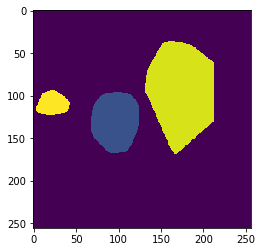

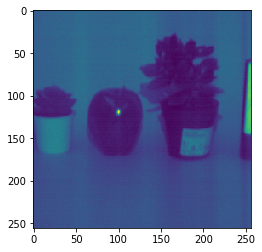

In [8]:
sample = iter(train_loader).next()
plt.imshow(sample['label'][0])
plt.show()
plt.imshow(sample['image'][0,0])
plt.show()

Populating the interactive namespace from numpy and matplotlib
['bg,' 'real orange' 'real lemons' 'fake lemons' 'real unknown'
 'fake unknown']


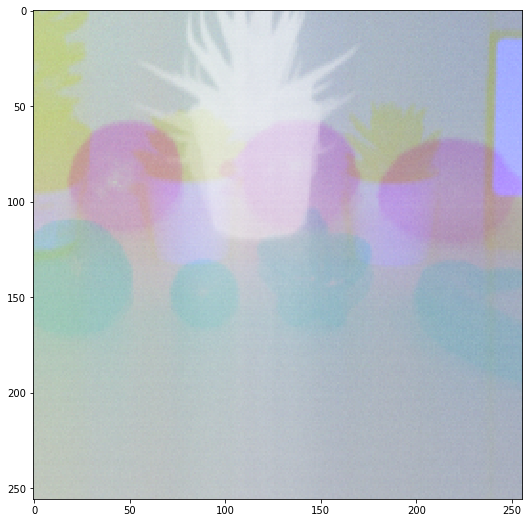

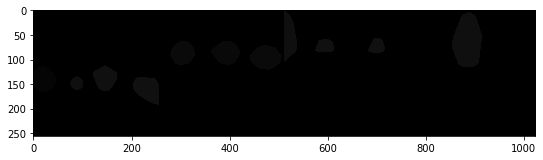

In [78]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
print(np.array(class_names)[sample['label'].unique()])
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'][:,0,:,:], padding=0).permute((1, 2, 0)))
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['label'][:,None,...], padding=0).permute((1, 2, 0)))

In [9]:
n_classes = len(class_names)
with open('pca_fruit_weights.pkl','rb') as file:
    pca = pickle.load(file)
pca

PCA(n_components=9)

In [10]:
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=9, out_channels=n_classes, pretrained=False).to(device)

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [11]:
class ModelHyperPCA(nn.Module):
    def __init__(self, unet, in_channels, out_channels, n_filters=9, PCA=True, *pargs, padding=0, **kargs):
        super(ModelHyper, self).__init__()
        self.identity = nn.Identity()
        self.n_filters = n_filters
        self.filters = nn.Linear(in_channels,n_filters)
        self.unet = unet
        if PCA:
            self.filters.weight.data = torch.from_numpy(pca.components_).float()
            self.filters.bias.data = torch.zeros(n_filters)
            self.bias = nn.Parameter(torch.from_numpy(pca.mean_).float())
        else:
            self.bias = nn.Parameter(torch.zeros((in_channels)))
    def forward(self, x):
        bs, ch, h, w = x.shape
        x = x.permute(0,2,3,1)
        x = x.flatten(end_dim=2, start_dim=1)
        x = x - self.bias
        x = self.filters(x)
        x = x.view(bs,h,w,self.n_filters).permute(0,3,1,2)
        x = self.unet(x)
        return x
    
model = ModelHyper(unet, 9, n_classes).to(device)
summary(model, (34,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 65536, 9]             315
            Conv2d-2         [-1, 32, 256, 256]           2,592
       BatchNorm2d-3         [-1, 32, 256, 256]              64
              ReLU-4         [-1, 32, 256, 256]               0
            Conv2d-5         [-1, 32, 256, 256]           9,216
       BatchNorm2d-6         [-1, 32, 256, 256]              64
              ReLU-7         [-1, 32, 256, 256]               0
         MaxPool2d-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,432
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [12]:
from utils import Metrics
loss_fn = nn.CrossEntropyLoss()

In [13]:
import os
import gc
import time
import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

train_pretrained=False
epochs = 100
batch_size = 8
learning_rate = 1e-4
workers = 1 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

In [18]:
run_id = 'segmentation_hyspec_gpu{}_n{}_bs{}_lr{}_pretrained{}_loss_{}_time_{}'.format(gpu_id, epochs, batch_size, learning_rate, train_pretrained,'cross_entropy', str(datetime.datetime.now().time())); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(params= model.parameters(),lr=learning_rate)

#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
metrics = Metrics(train_loader.dataset.dataset.num_classes, train_loader.dataset.dataset.class_names)

# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH


for epoch in range(epochs):
    model.train()

    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()
    
    
    iteration_losses = []

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['label'].long().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif i % (ITER_PER_REPORT) == 0:
            print('.', end='')

        #break # useful for quick debugging
    torch.cuda.empty_cache(); del x, y; gc.collect()

    # Validation after each epoch
    #model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['label'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    print('\nValidation stats ', metrics.get_table())
    # Save model
    iteration_losses.append(losses.avg)
    torch.save(model.state_dict(), save_path)
    np.save(run_id, iteration_losses)

ans = np.load(run_id+'.npy')
plt.plot(ans[:,0])
plt.plot(np.array(ans[:,1])-0.001)
plt.show()

print('\nTraining done. Model saved ({}).'.format(save_path))



Training segmentation_hyspec_gpu[0]_n100_bs8_lr0.0001_pretrainedFalse_loss_cross_entropy_time_07:17:12.835568

Epoch: [0][0/19]	Time 21.052 (21.052)	ETA 0:06:39	Training Loss 2.8217 (2.8217)

Epoch: [0][1/19]	Time 20.878 (41.930)	ETA 0:06:15	Training Loss 2.8131 (2.8174)

Epoch: [0][2/19]	Time 12.154 (54.084)	ETA 0:03:26	Training Loss 2.8065 (2.8138)

Epoch: [0][3/19]	Time 11.037 (65.121)	ETA 0:02:56	Training Loss 2.7942 (2.8089)

Epoch: [0][4/19]	Time 10.869 (75.990)	ETA 0:02:43	Training Loss 2.7886 (2.8048)

Epoch: [0][5/19]	Time 11.552 (87.542)	ETA 0:02:41	Training Loss 2.7751 (2.7999)

Epoch: [0][6/19]	Time 10.997 (98.540)	ETA 0:02:22	Training Loss 2.7747 (2.7963)

Epoch: [0][7/19]	Time 10.022 (108.562)	ETA 0:02:00	Training Loss 2.7664 (2.7925)

Epoch: [0][8/19]	Time 13.870 (122.432)	ETA 0:02:32	Training Loss 2.7606 (2.7890)

Epoch: [0][9/19]	Time 11.059 (133.491)	ETA 0:01:50	Training Loss 2.7530 (2.7854)

Epoch: [0][10/19]	Time 10.266 (143.756)	ETA 0:01:32	Training Loss 2.7516 (


Epoch: [3][0/19]	Time 6.962 (6.962)	ETA 0:02:12	Training Loss 2.6271 (2.6271)

Epoch: [3][1/19]	Time 10.634 (17.596)	ETA 0:03:11	Training Loss 2.6333 (2.6302)

Epoch: [3][2/19]	Time 5.989 (23.585)	ETA 0:01:41	Training Loss 2.6399 (2.6334)

Epoch: [3][3/19]	Time 1.785 (25.370)	ETA 0:00:28	Training Loss 2.6431 (2.6359)

Epoch: [3][4/19]	Time 9.691 (35.061)	ETA 0:02:25	Training Loss 2.6210 (2.6329)

Epoch: [3][5/19]	Time 7.921 (42.983)	ETA 0:01:50	Training Loss 2.6388 (2.6339)

Epoch: [3][6/19]	Time 4.393 (47.376)	ETA 0:00:57	Training Loss 2.6334 (2.6338)

Epoch: [3][7/19]	Time 6.616 (53.992)	ETA 0:01:19	Training Loss 2.6222 (2.6324)

Epoch: [3][8/19]	Time 9.222 (63.214)	ETA 0:01:41	Training Loss 2.6252 (2.6316)

Epoch: [3][9/19]	Time 6.536 (69.750)	ETA 0:01:05	Training Loss 2.6162 (2.6300)

Epoch: [3][10/19]	Time 7.683 (77.434)	ETA 0:01:09	Training Loss 2.6216 (2.6293)

Epoch: [3][11/19]	Time 9.563 (86.997)	ETA 0:01:16	Training Loss 2.6172 (2.6283)

Epoch: [3][12/19]	Time 5.018 (92.015)


Epoch: [6][0/19]	Time 5.295 (5.295)	ETA 0:01:40	Training Loss 2.5717 (2.5717)

Epoch: [6][1/19]	Time 2.795 (8.090)	ETA 0:00:50	Training Loss 2.5919 (2.5818)

Epoch: [6][2/19]	Time 4.634 (12.723)	ETA 0:01:18	Training Loss 2.5837 (2.5824)

Epoch: [6][3/19]	Time 6.956 (19.680)	ETA 0:01:51	Training Loss 2.5810 (2.5821)

Epoch: [6][4/19]	Time 7.973 (27.653)	ETA 0:01:59	Training Loss 2.5742 (2.5805)

Epoch: [6][5/19]	Time 1.927 (29.580)	ETA 0:00:26	Training Loss 2.5780 (2.5801)

Epoch: [6][6/19]	Time 8.229 (37.809)	ETA 0:01:46	Training Loss 2.5775 (2.5797)

Epoch: [6][7/19]	Time 5.353 (43.162)	ETA 0:01:04	Training Loss 2.5752 (2.5791)

Epoch: [6][8/19]	Time 3.212 (46.374)	ETA 0:00:35	Training Loss 2.5858 (2.5799)

Epoch: [6][9/19]	Time 1.931 (48.304)	ETA 0:00:19	Training Loss 2.5639 (2.5783)

Epoch: [6][10/19]	Time 6.393 (54.697)	ETA 0:00:57	Training Loss 2.5758 (2.5780)

Epoch: [6][11/19]	Time 4.784 (59.481)	ETA 0:00:38	Training Loss 2.5662 (2.5771)

Epoch: [6][12/19]	Time 4.537 (64.018)	E


Epoch: [9][0/19]	Time 1.898 (1.898)	ETA 0:00:36	Training Loss 2.5440 (2.5440)

Epoch: [9][1/19]	Time 1.673 (3.571)	ETA 0:00:30	Training Loss 2.5477 (2.5459)

Epoch: [9][2/19]	Time 1.467 (5.038)	ETA 0:00:24	Training Loss 2.5401 (2.5439)

Epoch: [9][3/19]	Time 1.076 (6.114)	ETA 0:00:17	Training Loss 2.5479 (2.5449)

Epoch: [9][4/19]	Time 1.500 (7.615)	ETA 0:00:22	Training Loss 2.5506 (2.5461)

Epoch: [9][5/19]	Time 1.432 (9.047)	ETA 0:00:20	Training Loss 2.5492 (2.5466)

Epoch: [9][6/19]	Time 2.447 (11.494)	ETA 0:00:31	Training Loss 2.5421 (2.5460)

Epoch: [9][7/19]	Time 1.497 (12.992)	ETA 0:00:17	Training Loss 2.5349 (2.5446)

Epoch: [9][8/19]	Time 1.612 (14.604)	ETA 0:00:17	Training Loss 2.5591 (2.5462)

Epoch: [9][9/19]	Time 2.050 (16.654)	ETA 0:00:20	Training Loss 2.5450 (2.5461)

Epoch: [9][10/19]	Time 1.944 (18.598)	ETA 0:00:17	Training Loss 2.5362 (2.5452)

Epoch: [9][11/19]	Time 2.763 (21.360)	ETA 0:00:22	Training Loss 2.5277 (2.5437)

Epoch: [9][12/19]	Time 1.525 (22.885)	ETA 0


Epoch: [12][0/19]	Time 1.879 (1.879)	ETA 0:00:35	Training Loss 2.5157 (2.5157)

Epoch: [12][1/19]	Time 1.486 (3.365)	ETA 0:00:26	Training Loss 2.5045 (2.5101)

Epoch: [12][2/19]	Time 2.329 (5.694)	ETA 0:00:39	Training Loss 2.5126 (2.5109)

Epoch: [12][3/19]	Time 2.155 (7.849)	ETA 0:00:34	Training Loss 2.5141 (2.5117)

Epoch: [12][4/19]	Time 1.654 (9.502)	ETA 0:00:24	Training Loss 2.5116 (2.5117)

Epoch: [12][5/19]	Time 1.208 (10.710)	ETA 0:00:16	Training Loss 2.5238 (2.5137)

Epoch: [12][6/19]	Time 1.735 (12.445)	ETA 0:00:22	Training Loss 2.5160 (2.5141)

Epoch: [12][7/19]	Time 1.606 (14.051)	ETA 0:00:19	Training Loss 2.5051 (2.5129)

Epoch: [12][8/19]	Time 2.390 (16.441)	ETA 0:00:26	Training Loss 2.5013 (2.5116)

Epoch: [12][9/19]	Time 1.411 (17.853)	ETA 0:00:14	Training Loss 2.5144 (2.5119)

Epoch: [12][10/19]	Time 1.927 (19.780)	ETA 0:00:17	Training Loss 2.4970 (2.5106)

Epoch: [12][11/19]	Time 1.580 (21.360)	ETA 0:00:12	Training Loss 2.5140 (2.5109)

Epoch: [12][12/19]	Time 1.340 


Epoch: [15][0/19]	Time 1.906 (1.906)	ETA 0:00:36	Training Loss 2.4865 (2.4865)

Epoch: [15][1/19]	Time 1.557 (3.463)	ETA 0:00:28	Training Loss 2.4859 (2.4862)

Epoch: [15][2/19]	Time 1.611 (5.074)	ETA 0:00:27	Training Loss 2.4793 (2.4839)

Epoch: [15][3/19]	Time 1.493 (6.568)	ETA 0:00:23	Training Loss 2.4756 (2.4818)

Epoch: [15][4/19]	Time 1.426 (7.994)	ETA 0:00:21	Training Loss 2.4946 (2.4844)

Epoch: [15][5/19]	Time 2.111 (10.105)	ETA 0:00:29	Training Loss 2.4875 (2.4849)

Epoch: [15][6/19]	Time 1.526 (11.631)	ETA 0:00:19	Training Loss 2.4795 (2.4841)

Epoch: [15][7/19]	Time 2.462 (14.092)	ETA 0:00:29	Training Loss 2.4839 (2.4841)

Epoch: [15][8/19]	Time 2.495 (16.588)	ETA 0:00:27	Training Loss 2.4759 (2.4832)

Epoch: [15][9/19]	Time 2.939 (19.527)	ETA 0:00:29	Training Loss 2.4874 (2.4836)

Epoch: [15][10/19]	Time 1.629 (21.156)	ETA 0:00:14	Training Loss 2.4682 (2.4822)

Epoch: [15][11/19]	Time 2.186 (23.342)	ETA 0:00:17	Training Loss 2.4797 (2.4820)

Epoch: [15][12/19]	Time 1.543 


Epoch: [18][0/19]	Time 1.680 (1.680)	ETA 0:00:31	Training Loss 2.4504 (2.4504)

Epoch: [18][1/19]	Time 1.383 (3.063)	ETA 0:00:24	Training Loss 2.4524 (2.4514)

Epoch: [18][2/19]	Time 2.568 (5.630)	ETA 0:00:43	Training Loss 2.4528 (2.4519)

Epoch: [18][3/19]	Time 1.212 (6.843)	ETA 0:00:19	Training Loss 2.4438 (2.4499)

Epoch: [18][4/19]	Time 1.307 (8.149)	ETA 0:00:19	Training Loss 2.4515 (2.4502)

Epoch: [18][5/19]	Time 1.367 (9.516)	ETA 0:00:19	Training Loss 2.4570 (2.4513)

Epoch: [18][6/19]	Time 1.472 (10.988)	ETA 0:00:19	Training Loss 2.4542 (2.4517)

Epoch: [18][7/19]	Time 1.550 (12.537)	ETA 0:00:18	Training Loss 2.4669 (2.4536)

Epoch: [18][8/19]	Time 1.654 (14.191)	ETA 0:00:18	Training Loss 2.4454 (2.4527)

Epoch: [18][9/19]	Time 1.215 (15.406)	ETA 0:00:12	Training Loss 2.4413 (2.4516)

Epoch: [18][10/19]	Time 2.120 (17.526)	ETA 0:00:19	Training Loss 2.4439 (2.4509)

Epoch: [18][11/19]	Time 1.218 (18.745)	ETA 0:00:09	Training Loss 2.4613 (2.4518)

Epoch: [18][12/19]	Time 1.640 (


Epoch: [21][0/19]	Time 1.672 (1.672)	ETA 0:00:31	Training Loss 2.4299 (2.4299)

Epoch: [21][1/19]	Time 1.474 (3.146)	ETA 0:00:26	Training Loss 2.4172 (2.4235)

Epoch: [21][2/19]	Time 1.845 (4.991)	ETA 0:00:31	Training Loss 2.4168 (2.4213)

Epoch: [21][3/19]	Time 1.151 (6.142)	ETA 0:00:18	Training Loss 2.4207 (2.4211)

Epoch: [21][4/19]	Time 1.835 (7.977)	ETA 0:00:27	Training Loss 2.4194 (2.4208)

Epoch: [21][5/19]	Time 1.322 (9.299)	ETA 0:00:18	Training Loss 2.4233 (2.4212)

Epoch: [21][6/19]	Time 1.665 (10.964)	ETA 0:00:21	Training Loss 2.4330 (2.4229)

Epoch: [21][7/19]	Time 1.763 (12.727)	ETA 0:00:21	Training Loss 2.4309 (2.4239)

Epoch: [21][8/19]	Time 1.649 (14.376)	ETA 0:00:18	Training Loss 2.4296 (2.4245)

Epoch: [21][9/19]	Time 1.243 (15.619)	ETA 0:00:12	Training Loss 2.4292 (2.4250)

Epoch: [21][10/19]	Time 1.565 (17.185)	ETA 0:00:14	Training Loss 2.4307 (2.4255)

Epoch: [21][11/19]	Time 2.109 (19.293)	ETA 0:00:16	Training Loss 2.4142 (2.4246)

Epoch: [21][12/19]	Time 1.606 (


Epoch: [24][0/19]	Time 1.843 (1.843)	ETA 0:00:35	Training Loss 2.3985 (2.3985)

Epoch: [24][1/19]	Time 1.553 (3.397)	ETA 0:00:27	Training Loss 2.4009 (2.3997)

Epoch: [24][2/19]	Time 1.576 (4.973)	ETA 0:00:26	Training Loss 2.3951 (2.3982)

Epoch: [24][3/19]	Time 1.190 (6.163)	ETA 0:00:19	Training Loss 2.4044 (2.3997)

Epoch: [24][4/19]	Time 1.275 (7.438)	ETA 0:00:19	Training Loss 2.3952 (2.3988)

Epoch: [24][5/19]	Time 1.580 (9.018)	ETA 0:00:22	Training Loss 2.3925 (2.3978)

Epoch: [24][6/19]	Time 1.689 (10.707)	ETA 0:00:21	Training Loss 2.3846 (2.3959)

Epoch: [24][7/19]	Time 1.383 (12.090)	ETA 0:00:16	Training Loss 2.3849 (2.3945)

Epoch: [24][8/19]	Time 2.732 (14.822)	ETA 0:00:30	Training Loss 2.3895 (2.3940)

Epoch: [24][9/19]	Time 1.331 (16.152)	ETA 0:00:13	Training Loss 2.3993 (2.3945)

Epoch: [24][10/19]	Time 1.965 (18.118)	ETA 0:00:17	Training Loss 2.4006 (2.3950)

Epoch: [24][11/19]	Time 1.220 (19.338)	ETA 0:00:09	Training Loss 2.3859 (2.3943)

Epoch: [24][12/19]	Time 1.428 (


Epoch: [27][0/19]	Time 1.969 (1.969)	ETA 0:00:37	Training Loss 2.3714 (2.3714)

Epoch: [27][1/19]	Time 1.306 (3.274)	ETA 0:00:23	Training Loss 2.3943 (2.3828)

Epoch: [27][2/19]	Time 2.179 (5.454)	ETA 0:00:37	Training Loss 2.3609 (2.3755)

Epoch: [27][3/19]	Time 1.083 (6.536)	ETA 0:00:17	Training Loss 2.3635 (2.3725)

Epoch: [27][4/19]	Time 2.009 (8.545)	ETA 0:00:30	Training Loss 2.3796 (2.3739)

Epoch: [27][5/19]	Time 1.182 (9.727)	ETA 0:00:16	Training Loss 2.3653 (2.3725)

Epoch: [27][6/19]	Time 1.721 (11.448)	ETA 0:00:22	Training Loss 2.3728 (2.3725)

Epoch: [27][7/19]	Time 1.483 (12.931)	ETA 0:00:17	Training Loss 2.3649 (2.3716)

Epoch: [27][8/19]	Time 1.623 (14.555)	ETA 0:00:17	Training Loss 2.3584 (2.3701)

Epoch: [27][9/19]	Time 1.186 (15.740)	ETA 0:00:11	Training Loss 2.3655 (2.3697)

Epoch: [27][10/19]	Time 1.999 (17.739)	ETA 0:00:17	Training Loss 2.3600 (2.3688)

Epoch: [27][11/19]	Time 1.320 (19.059)	ETA 0:00:10	Training Loss 2.3693 (2.3688)

Epoch: [27][12/19]	Time 1.414 (


Epoch: [30][0/19]	Time 1.937 (1.937)	ETA 0:00:36	Training Loss 2.3382 (2.3382)

Epoch: [30][1/19]	Time 1.586 (3.523)	ETA 0:00:28	Training Loss 2.3435 (2.3409)

Epoch: [30][2/19]	Time 1.635 (5.158)	ETA 0:00:27	Training Loss 2.3423 (2.3413)

Epoch: [30][3/19]	Time 2.175 (7.333)	ETA 0:00:34	Training Loss 2.3367 (2.3402)

Epoch: [30][4/19]	Time 1.274 (8.607)	ETA 0:00:19	Training Loss 2.3409 (2.3403)

Epoch: [30][5/19]	Time 1.244 (9.851)	ETA 0:00:17	Training Loss 2.3414 (2.3405)

Epoch: [30][6/19]	Time 1.948 (11.799)	ETA 0:00:25	Training Loss 2.3358 (2.3398)

Epoch: [30][7/19]	Time 1.484 (13.283)	ETA 0:00:17	Training Loss 2.3360 (2.3394)

Epoch: [30][8/19]	Time 1.365 (14.649)	ETA 0:00:15	Training Loss 2.3386 (2.3393)

Epoch: [30][9/19]	Time 1.345 (15.994)	ETA 0:00:13	Training Loss 2.3485 (2.3402)

Epoch: [30][10/19]	Time 2.130 (18.124)	ETA 0:00:19	Training Loss 2.3325 (2.3395)

Epoch: [30][11/19]	Time 1.366 (19.490)	ETA 0:00:10	Training Loss 2.3496 (2.3403)

Epoch: [30][12/19]	Time 1.376 (


Epoch: [33][0/19]	Time 1.784 (1.784)	ETA 0:00:33	Training Loss 2.3356 (2.3356)

Epoch: [33][1/19]	Time 1.861 (3.646)	ETA 0:00:33	Training Loss 2.3116 (2.3236)

Epoch: [33][2/19]	Time 2.006 (5.652)	ETA 0:00:34	Training Loss 2.3143 (2.3205)

Epoch: [33][3/19]	Time 1.473 (7.124)	ETA 0:00:23	Training Loss 2.3260 (2.3219)

Epoch: [33][4/19]	Time 1.532 (8.656)	ETA 0:00:22	Training Loss 2.3267 (2.3228)

Epoch: [33][5/19]	Time 1.705 (10.361)	ETA 0:00:23	Training Loss 2.3251 (2.3232)

Epoch: [33][6/19]	Time 1.587 (11.948)	ETA 0:00:20	Training Loss 2.3190 (2.3226)

Epoch: [33][7/19]	Time 1.587 (13.535)	ETA 0:00:19	Training Loss 2.3133 (2.3215)

Epoch: [33][8/19]	Time 1.503 (15.038)	ETA 0:00:16	Training Loss 2.3168 (2.3209)

Epoch: [33][9/19]	Time 1.441 (16.479)	ETA 0:00:14	Training Loss 2.3067 (2.3195)

Epoch: [33][10/19]	Time 1.434 (17.913)	ETA 0:00:12	Training Loss 2.3243 (2.3200)

Epoch: [33][11/19]	Time 1.584 (19.497)	ETA 0:00:12	Training Loss 2.3091 (2.3190)

Epoch: [33][12/19]	Time 2.321 


Epoch: [36][0/19]	Time 1.687 (1.687)	ETA 0:00:32	Training Loss 2.2921 (2.2921)

Epoch: [36][1/19]	Time 1.635 (3.322)	ETA 0:00:29	Training Loss 2.3058 (2.2989)

Epoch: [36][2/19]	Time 1.332 (4.654)	ETA 0:00:22	Training Loss 2.2863 (2.2947)

Epoch: [36][3/19]	Time 1.646 (6.300)	ETA 0:00:26	Training Loss 2.2958 (2.2950)

Epoch: [36][4/19]	Time 1.260 (7.560)	ETA 0:00:18	Training Loss 2.3031 (2.2966)

Epoch: [36][5/19]	Time 1.805 (9.365)	ETA 0:00:25	Training Loss 2.2941 (2.2962)

Epoch: [36][6/19]	Time 1.608 (10.973)	ETA 0:00:20	Training Loss 2.2895 (2.2952)

Epoch: [36][7/19]	Time 1.924 (12.896)	ETA 0:00:23	Training Loss 2.2993 (2.2957)

Epoch: [36][8/19]	Time 1.408 (14.304)	ETA 0:00:15	Training Loss 2.2874 (2.2948)

Epoch: [36][9/19]	Time 1.635 (15.939)	ETA 0:00:16	Training Loss 2.3020 (2.2955)

Epoch: [36][10/19]	Time 1.933 (17.873)	ETA 0:00:17	Training Loss 2.3203 (2.2978)

Epoch: [36][11/19]	Time 1.743 (19.615)	ETA 0:00:13	Training Loss 2.3068 (2.2985)

Epoch: [36][12/19]	Time 1.576 (


Epoch: [39][0/19]	Time 2.556 (2.556)	ETA 0:00:48	Training Loss 2.2820 (2.2820)

Epoch: [39][1/19]	Time 1.522 (4.077)	ETA 0:00:27	Training Loss 2.2810 (2.2815)

Epoch: [39][2/19]	Time 1.535 (5.613)	ETA 0:00:26	Training Loss 2.2667 (2.2766)

Epoch: [39][3/19]	Time 1.785 (7.398)	ETA 0:00:28	Training Loss 2.2672 (2.2742)

Epoch: [39][4/19]	Time 1.568 (8.966)	ETA 0:00:23	Training Loss 2.2794 (2.2752)

Epoch: [39][5/19]	Time 3.041 (12.006)	ETA 0:00:42	Training Loss 2.2723 (2.2748)

Epoch: [39][6/19]	Time 1.773 (13.780)	ETA 0:00:23	Training Loss 2.2731 (2.2745)

Epoch: [39][7/19]	Time 1.726 (15.505)	ETA 0:00:20	Training Loss 2.2744 (2.2745)

Epoch: [39][8/19]	Time 2.743 (18.249)	ETA 0:00:30	Training Loss 2.2840 (2.2756)

Epoch: [39][9/19]	Time 1.287 (19.536)	ETA 0:00:12	Training Loss 2.2749 (2.2755)

Epoch: [39][10/19]	Time 1.983 (21.519)	ETA 0:00:17	Training Loss 2.2709 (2.2751)

Epoch: [39][11/19]	Time 2.149 (23.668)	ETA 0:00:17	Training Loss 2.2636 (2.2741)

Epoch: [39][12/19]	Time 1.804 


Epoch: [42][0/19]	Time 1.856 (1.856)	ETA 0:00:35	Training Loss 2.2505 (2.2505)

Epoch: [42][1/19]	Time 1.715 (3.571)	ETA 0:00:30	Training Loss 2.2455 (2.2480)

Epoch: [42][2/19]	Time 1.636 (5.207)	ETA 0:00:27	Training Loss 2.2550 (2.2503)

Epoch: [42][3/19]	Time 1.902 (7.109)	ETA 0:00:30	Training Loss 2.2485 (2.2499)

Epoch: [42][4/19]	Time 1.573 (8.681)	ETA 0:00:23	Training Loss 2.2711 (2.2541)

Epoch: [42][5/19]	Time 1.460 (10.142)	ETA 0:00:20	Training Loss 2.2841 (2.2591)

Epoch: [42][6/19]	Time 2.113 (12.255)	ETA 0:00:27	Training Loss 2.2608 (2.2594)

Epoch: [42][7/19]	Time 1.729 (13.984)	ETA 0:00:20	Training Loss 2.2725 (2.2610)

Epoch: [42][8/19]	Time 1.726 (15.710)	ETA 0:00:18	Training Loss 2.2553 (2.2604)

Epoch: [42][9/19]	Time 1.145 (16.855)	ETA 0:00:11	Training Loss 2.2572 (2.2601)

Epoch: [42][10/19]	Time 1.567 (18.422)	ETA 0:00:14	Training Loss 2.2555 (2.2596)

Epoch: [42][11/19]	Time 1.886 (20.308)	ETA 0:00:15	Training Loss 2.2591 (2.2596)

Epoch: [42][12/19]	Time 1.815 


Epoch: [45][0/19]	Time 2.970 (2.970)	ETA 0:00:56	Training Loss 2.2330 (2.2330)

Epoch: [45][1/19]	Time 1.908 (4.878)	ETA 0:00:34	Training Loss 2.2614 (2.2472)

Epoch: [45][2/19]	Time 1.376 (6.254)	ETA 0:00:23	Training Loss 2.2317 (2.2420)

Epoch: [45][3/19]	Time 1.552 (7.806)	ETA 0:00:24	Training Loss 2.2516 (2.2444)

Epoch: [45][4/19]	Time 1.837 (9.643)	ETA 0:00:27	Training Loss 2.2425 (2.2441)

Epoch: [45][5/19]	Time 1.539 (11.182)	ETA 0:00:21	Training Loss 2.2328 (2.2422)

Epoch: [45][6/19]	Time 1.740 (12.922)	ETA 0:00:22	Training Loss 2.2345 (2.2411)

Epoch: [45][7/19]	Time 1.756 (14.678)	ETA 0:00:21	Training Loss 2.2347 (2.2403)

Epoch: [45][8/19]	Time 2.736 (17.414)	ETA 0:00:30	Training Loss 2.2539 (2.2418)

Epoch: [45][9/19]	Time 1.577 (18.991)	ETA 0:00:15	Training Loss 2.2447 (2.2421)

Epoch: [45][10/19]	Time 1.784 (20.774)	ETA 0:00:16	Training Loss 2.2240 (2.2404)

Epoch: [45][11/19]	Time 1.144 (21.918)	ETA 0:00:09	Training Loss 2.2561 (2.2417)

Epoch: [45][12/19]	Time 2.406 


Epoch: [48][0/19]	Time 2.773 (2.773)	ETA 0:00:52	Training Loss 2.2160 (2.2160)

Epoch: [48][1/19]	Time 2.014 (4.787)	ETA 0:00:36	Training Loss 2.2170 (2.2165)

Epoch: [48][2/19]	Time 2.645 (7.432)	ETA 0:00:44	Training Loss 2.2311 (2.2214)

Epoch: [48][3/19]	Time 1.424 (8.856)	ETA 0:00:22	Training Loss 2.2146 (2.2197)

Epoch: [48][4/19]	Time 2.473 (11.329)	ETA 0:00:37	Training Loss 2.2044 (2.2166)

Epoch: [48][5/19]	Time 2.770 (14.099)	ETA 0:00:38	Training Loss 2.2225 (2.2176)

Epoch: [48][6/19]	Time 1.679 (15.778)	ETA 0:00:21	Training Loss 2.2122 (2.2168)

Epoch: [48][7/19]	Time 1.689 (17.467)	ETA 0:00:20	Training Loss 2.2098 (2.2160)

Epoch: [48][8/19]	Time 2.014 (19.481)	ETA 0:00:22	Training Loss 2.2272 (2.2172)

Epoch: [48][9/19]	Time 2.395 (21.876)	ETA 0:00:23	Training Loss 2.2050 (2.2160)

Epoch: [48][10/19]	Time 1.839 (23.714)	ETA 0:00:16	Training Loss 2.2064 (2.2151)

Epoch: [48][11/19]	Time 2.161 (25.875)	ETA 0:00:17	Training Loss 2.2205 (2.2156)

Epoch: [48][12/19]	Time 2.633


Epoch: [51][0/19]	Time 2.471 (2.471)	ETA 0:00:46	Training Loss 2.2084 (2.2084)

Epoch: [51][1/19]	Time 1.618 (4.090)	ETA 0:00:29	Training Loss 2.2112 (2.2098)

Epoch: [51][2/19]	Time 1.324 (5.414)	ETA 0:00:22	Training Loss 2.2091 (2.2095)

Epoch: [51][3/19]	Time 1.486 (6.900)	ETA 0:00:23	Training Loss 2.1923 (2.2052)

Epoch: [51][4/19]	Time 1.186 (8.087)	ETA 0:00:17	Training Loss 2.1898 (2.2021)

Epoch: [51][5/19]	Time 1.162 (9.249)	ETA 0:00:16	Training Loss 2.2029 (2.2023)

Epoch: [51][6/19]	Time 2.198 (11.447)	ETA 0:00:28	Training Loss 2.2137 (2.2039)

Epoch: [51][7/19]	Time 1.566 (13.012)	ETA 0:00:18	Training Loss 2.1989 (2.2033)

Epoch: [51][8/19]	Time 2.643 (15.655)	ETA 0:00:29	Training Loss 2.2087 (2.2039)

Epoch: [51][9/19]	Time 2.120 (17.775)	ETA 0:00:21	Training Loss 2.1871 (2.2022)

Epoch: [51][10/19]	Time 2.491 (20.266)	ETA 0:00:22	Training Loss 2.1983 (2.2019)

Epoch: [51][11/19]	Time 1.536 (21.802)	ETA 0:00:12	Training Loss 2.2022 (2.2019)

Epoch: [51][12/19]	Time 1.420 (


Epoch: [54][0/19]	Time 1.690 (1.690)	ETA 0:00:32	Training Loss 2.1908 (2.1908)

Epoch: [54][1/19]	Time 1.713 (3.403)	ETA 0:00:30	Training Loss 2.2100 (2.2004)

Epoch: [54][2/19]	Time 1.337 (4.740)	ETA 0:00:22	Training Loss 2.1777 (2.1928)

Epoch: [54][3/19]	Time 1.370 (6.109)	ETA 0:00:21	Training Loss 2.2096 (2.1970)

Epoch: [54][4/19]	Time 1.432 (7.542)	ETA 0:00:21	Training Loss 2.1835 (2.1943)

Epoch: [54][5/19]	Time 1.240 (8.782)	ETA 0:00:17	Training Loss 2.1848 (2.1927)

Epoch: [54][6/19]	Time 1.713 (10.495)	ETA 0:00:22	Training Loss 2.1738 (2.1900)

Epoch: [54][7/19]	Time 1.705 (12.200)	ETA 0:00:20	Training Loss 2.1870 (2.1897)

Epoch: [54][8/19]	Time 1.570 (13.770)	ETA 0:00:17	Training Loss 2.1723 (2.1877)

Epoch: [54][9/19]	Time 1.443 (15.213)	ETA 0:00:14	Training Loss 2.1928 (2.1882)

Epoch: [54][10/19]	Time 2.381 (17.594)	ETA 0:00:21	Training Loss 2.1777 (2.1873)

Epoch: [54][11/19]	Time 2.190 (19.784)	ETA 0:00:17	Training Loss 2.1768 (2.1864)

Epoch: [54][12/19]	Time 1.410 (


Epoch: [57][0/19]	Time 2.033 (2.033)	ETA 0:00:38	Training Loss 2.1768 (2.1768)

Epoch: [57][1/19]	Time 1.466 (3.499)	ETA 0:00:26	Training Loss 2.1688 (2.1728)

Epoch: [57][2/19]	Time 1.569 (5.068)	ETA 0:00:26	Training Loss 2.1667 (2.1708)

Epoch: [57][3/19]	Time 1.517 (6.584)	ETA 0:00:24	Training Loss 2.1704 (2.1707)

Epoch: [57][4/19]	Time 2.643 (9.227)	ETA 0:00:39	Training Loss 2.1671 (2.1700)

Epoch: [57][5/19]	Time 1.393 (10.620)	ETA 0:00:19	Training Loss 2.1654 (2.1692)

Epoch: [57][6/19]	Time 2.394 (13.014)	ETA 0:00:31	Training Loss 2.1654 (2.1687)

Epoch: [57][7/19]	Time 1.340 (14.354)	ETA 0:00:16	Training Loss 2.1662 (2.1684)

Epoch: [57][8/19]	Time 1.284 (15.638)	ETA 0:00:14	Training Loss 2.1654 (2.1680)

Epoch: [57][9/19]	Time 1.422 (17.060)	ETA 0:00:14	Training Loss 2.1716 (2.1684)

Epoch: [57][10/19]	Time 1.451 (18.511)	ETA 0:00:13	Training Loss 2.1514 (2.1668)

Epoch: [57][11/19]	Time 1.967 (20.477)	ETA 0:00:15	Training Loss 2.1526 (2.1657)

Epoch: [57][12/19]	Time 1.522 


Epoch: [60][0/19]	Time 1.618 (1.618)	ETA 0:00:30	Training Loss 2.1486 (2.1486)

Epoch: [60][1/19]	Time 1.530 (3.148)	ETA 0:00:27	Training Loss 2.1557 (2.1522)

Epoch: [60][2/19]	Time 2.189 (5.336)	ETA 0:00:37	Training Loss 2.1498 (2.1514)

Epoch: [60][3/19]	Time 1.431 (6.768)	ETA 0:00:22	Training Loss 2.1642 (2.1546)

Epoch: [60][4/19]	Time 2.034 (8.802)	ETA 0:00:30	Training Loss 2.1456 (2.1528)

Epoch: [60][5/19]	Time 1.272 (10.074)	ETA 0:00:17	Training Loss 2.1530 (2.1528)

Epoch: [60][6/19]	Time 1.452 (11.526)	ETA 0:00:18	Training Loss 2.1587 (2.1537)

Epoch: [60][7/19]	Time 1.663 (13.189)	ETA 0:00:19	Training Loss 2.1413 (2.1521)

Epoch: [60][8/19]	Time 1.626 (14.815)	ETA 0:00:17	Training Loss 2.1499 (2.1519)

Epoch: [60][9/19]	Time 1.333 (16.148)	ETA 0:00:13	Training Loss 2.1447 (2.1512)

Epoch: [60][10/19]	Time 1.677 (17.825)	ETA 0:00:15	Training Loss 2.1377 (2.1499)

Epoch: [60][11/19]	Time 1.493 (19.317)	ETA 0:00:11	Training Loss 2.1390 (2.1490)

Epoch: [60][12/19]	Time 1.411 


Epoch: [63][0/19]	Time 1.750 (1.750)	ETA 0:00:33	Training Loss 2.1550 (2.1550)

Epoch: [63][1/19]	Time 1.443 (3.193)	ETA 0:00:25	Training Loss 2.1285 (2.1417)

Epoch: [63][2/19]	Time 1.319 (4.512)	ETA 0:00:22	Training Loss 2.1250 (2.1361)

Epoch: [63][3/19]	Time 1.685 (6.197)	ETA 0:00:26	Training Loss 2.1244 (2.1332)

Epoch: [63][4/19]	Time 1.598 (7.795)	ETA 0:00:23	Training Loss 2.1396 (2.1345)

Epoch: [63][5/19]	Time 1.363 (9.158)	ETA 0:00:19	Training Loss 2.1304 (2.1338)

Epoch: [63][6/19]	Time 2.034 (11.193)	ETA 0:00:26	Training Loss 2.1374 (2.1343)

Epoch: [63][7/19]	Time 1.454 (12.646)	ETA 0:00:17	Training Loss 2.1538 (2.1367)

Epoch: [63][8/19]	Time 2.334 (14.980)	ETA 0:00:25	Training Loss 2.1495 (2.1382)

Epoch: [63][9/19]	Time 1.306 (16.286)	ETA 0:00:13	Training Loss 2.1296 (2.1373)

Epoch: [63][10/19]	Time 1.506 (17.792)	ETA 0:00:13	Training Loss 2.1615 (2.1395)

Epoch: [63][11/19]	Time 1.158 (18.951)	ETA 0:00:09	Training Loss 2.1295 (2.1387)

Epoch: [63][12/19]	Time 1.327 (


Epoch: [66][0/19]	Time 2.084 (2.084)	ETA 0:00:39	Training Loss 2.1246 (2.1246)

Epoch: [66][1/19]	Time 2.284 (4.369)	ETA 0:00:41	Training Loss 2.1455 (2.1350)

Epoch: [66][2/19]	Time 1.236 (5.605)	ETA 0:00:21	Training Loss 2.1229 (2.1310)

Epoch: [66][3/19]	Time 1.347 (6.951)	ETA 0:00:21	Training Loss 2.1688 (2.1404)

Epoch: [66][4/19]	Time 2.474 (9.425)	ETA 0:00:37	Training Loss 2.1309 (2.1385)

Epoch: [66][5/19]	Time 1.737 (11.162)	ETA 0:00:24	Training Loss 2.1293 (2.1370)

Epoch: [66][6/19]	Time 1.672 (12.833)	ETA 0:00:21	Training Loss 2.1143 (2.1338)

Epoch: [66][7/19]	Time 1.589 (14.423)	ETA 0:00:19	Training Loss 2.1308 (2.1334)

Epoch: [66][8/19]	Time 2.046 (16.469)	ETA 0:00:22	Training Loss 2.1484 (2.1351)

Epoch: [66][9/19]	Time 1.172 (17.641)	ETA 0:00:11	Training Loss 2.1208 (2.1336)

Epoch: [66][10/19]	Time 1.830 (19.471)	ETA 0:00:16	Training Loss 2.1565 (2.1357)

Epoch: [66][11/19]	Time 1.308 (20.779)	ETA 0:00:10	Training Loss 2.1185 (2.1343)

Epoch: [66][12/19]	Time 2.088 


Epoch: [69][0/19]	Time 1.847 (1.847)	ETA 0:00:35	Training Loss 2.1059 (2.1059)

Epoch: [69][1/19]	Time 1.818 (3.664)	ETA 0:00:32	Training Loss 2.1334 (2.1196)

Epoch: [69][2/19]	Time 1.551 (5.215)	ETA 0:00:26	Training Loss 2.1239 (2.1211)

Epoch: [69][3/19]	Time 2.628 (7.844)	ETA 0:00:42	Training Loss 2.1117 (2.1187)

Epoch: [69][4/19]	Time 1.600 (9.444)	ETA 0:00:23	Training Loss 2.0976 (2.1145)

Epoch: [69][5/19]	Time 1.919 (11.363)	ETA 0:00:26	Training Loss 2.1289 (2.1169)

Epoch: [69][6/19]	Time 1.596 (12.959)	ETA 0:00:20	Training Loss 2.1003 (2.1145)

Epoch: [69][7/19]	Time 1.586 (14.545)	ETA 0:00:19	Training Loss 2.1064 (2.1135)

Epoch: [69][8/19]	Time 1.548 (16.093)	ETA 0:00:17	Training Loss 2.1041 (2.1125)

Epoch: [69][9/19]	Time 0.975 (17.069)	ETA 0:00:09	Training Loss 2.1178 (2.1130)

Epoch: [69][10/19]	Time 1.779 (18.847)	ETA 0:00:16	Training Loss 2.1154 (2.1132)

Epoch: [69][11/19]	Time 1.148 (19.995)	ETA 0:00:09	Training Loss 2.1030 (2.1124)

Epoch: [69][12/19]	Time 1.547 


Epoch: [72][0/19]	Time 1.817 (1.817)	ETA 0:00:34	Training Loss 2.0892 (2.0892)

Epoch: [72][1/19]	Time 1.502 (3.319)	ETA 0:00:27	Training Loss 2.1013 (2.0952)

Epoch: [72][2/19]	Time 1.517 (4.836)	ETA 0:00:25	Training Loss 2.0916 (2.0940)

Epoch: [72][3/19]	Time 1.885 (6.721)	ETA 0:00:30	Training Loss 2.0940 (2.0940)

Epoch: [72][4/19]	Time 1.474 (8.195)	ETA 0:00:22	Training Loss 2.1041 (2.0960)

Epoch: [72][5/19]	Time 1.227 (9.422)	ETA 0:00:17	Training Loss 2.1128 (2.0988)

Epoch: [72][6/19]	Time 1.588 (11.010)	ETA 0:00:20	Training Loss 2.1142 (2.1010)

Epoch: [72][7/19]	Time 1.838 (12.848)	ETA 0:00:22	Training Loss 2.0932 (2.1001)

Epoch: [72][8/19]	Time 1.706 (14.554)	ETA 0:00:18	Training Loss 2.0932 (2.0993)

Epoch: [72][9/19]	Time 1.775 (16.328)	ETA 0:00:17	Training Loss 2.1017 (2.0995)

Epoch: [72][10/19]	Time 1.634 (17.963)	ETA 0:00:14	Training Loss 2.1113 (2.1006)

Epoch: [72][11/19]	Time 1.251 (19.214)	ETA 0:00:10	Training Loss 2.1071 (2.1011)

Epoch: [72][12/19]	Time 1.459 (


Epoch: [75][0/19]	Time 2.626 (2.626)	ETA 0:00:49	Training Loss 2.1255 (2.1255)

Epoch: [75][1/19]	Time 1.434 (4.059)	ETA 0:00:25	Training Loss 2.0795 (2.1025)

Epoch: [75][2/19]	Time 1.266 (5.325)	ETA 0:00:21	Training Loss 2.0843 (2.0964)

Epoch: [75][3/19]	Time 1.259 (6.584)	ETA 0:00:20	Training Loss 2.0984 (2.0969)

Epoch: [75][4/19]	Time 1.355 (7.938)	ETA 0:00:20	Training Loss 2.1097 (2.0995)

Epoch: [75][5/19]	Time 1.178 (9.116)	ETA 0:00:16	Training Loss 2.0893 (2.0978)

Epoch: [75][6/19]	Time 1.453 (10.569)	ETA 0:00:18	Training Loss 2.0829 (2.0957)

Epoch: [75][7/19]	Time 2.768 (13.338)	ETA 0:00:33	Training Loss 2.0921 (2.0952)

Epoch: [75][8/19]	Time 1.604 (14.941)	ETA 0:00:17	Training Loss 2.0816 (2.0937)

Epoch: [75][9/19]	Time 2.886 (17.828)	ETA 0:00:28	Training Loss 2.1317 (2.0975)

Epoch: [75][10/19]	Time 2.193 (20.020)	ETA 0:00:19	Training Loss 2.0823 (2.0961)

Epoch: [75][11/19]	Time 2.601 (22.621)	ETA 0:00:20	Training Loss 2.0964 (2.0961)

Epoch: [75][12/19]	Time 1.556 (


Epoch: [78][0/19]	Time 1.757 (1.757)	ETA 0:00:33	Training Loss 2.0853 (2.0853)

Epoch: [78][1/19]	Time 1.655 (3.411)	ETA 0:00:29	Training Loss 2.0885 (2.0869)

Epoch: [78][2/19]	Time 1.415 (4.826)	ETA 0:00:24	Training Loss 2.0750 (2.0829)

Epoch: [78][3/19]	Time 1.180 (6.007)	ETA 0:00:18	Training Loss 2.0663 (2.0787)

Epoch: [78][4/19]	Time 1.263 (7.269)	ETA 0:00:18	Training Loss 2.0793 (2.0789)

Epoch: [78][5/19]	Time 1.667 (8.936)	ETA 0:00:23	Training Loss 2.0997 (2.0823)

Epoch: [78][6/19]	Time 2.111 (11.047)	ETA 0:00:27	Training Loss 2.0786 (2.0818)

Epoch: [78][7/19]	Time 1.840 (12.887)	ETA 0:00:22	Training Loss 2.1089 (2.0852)

Epoch: [78][8/19]	Time 1.577 (14.464)	ETA 0:00:17	Training Loss 2.0920 (2.0859)

Epoch: [78][9/19]	Time 1.553 (16.017)	ETA 0:00:15	Training Loss 2.0737 (2.0847)

Epoch: [78][10/19]	Time 1.726 (17.744)	ETA 0:00:15	Training Loss 2.1234 (2.0882)

Epoch: [78][11/19]	Time 1.705 (19.449)	ETA 0:00:13	Training Loss 2.0685 (2.0866)

Epoch: [78][12/19]	Time 1.354 (


Epoch: [81][0/19]	Time 2.041 (2.041)	ETA 0:00:38	Training Loss 2.0867 (2.0867)

Epoch: [81][1/19]	Time 1.518 (3.559)	ETA 0:00:27	Training Loss 2.0670 (2.0768)

Epoch: [81][2/19]	Time 1.936 (5.495)	ETA 0:00:32	Training Loss 2.1089 (2.0875)

Epoch: [81][3/19]	Time 1.295 (6.789)	ETA 0:00:20	Training Loss 2.0915 (2.0885)

Epoch: [81][4/19]	Time 1.911 (8.700)	ETA 0:00:28	Training Loss 2.0830 (2.0874)

Epoch: [81][5/19]	Time 1.785 (10.485)	ETA 0:00:24	Training Loss 2.0679 (2.0842)

Epoch: [81][6/19]	Time 1.576 (12.061)	ETA 0:00:20	Training Loss 2.0721 (2.0824)

Epoch: [81][7/19]	Time 1.442 (13.503)	ETA 0:00:17	Training Loss 2.0689 (2.0807)

Epoch: [81][8/19]	Time 2.115 (15.618)	ETA 0:00:23	Training Loss 2.0662 (2.0791)

Epoch: [81][9/19]	Time 1.464 (17.082)	ETA 0:00:14	Training Loss 2.0811 (2.0793)

Epoch: [81][10/19]	Time 2.119 (19.202)	ETA 0:00:19	Training Loss 2.0690 (2.0784)

Epoch: [81][11/19]	Time 2.030 (21.232)	ETA 0:00:16	Training Loss 2.0852 (2.0789)

Epoch: [81][12/19]	Time 1.625 


Epoch: [84][0/19]	Time 1.738 (1.738)	ETA 0:00:33	Training Loss 2.0799 (2.0799)

Epoch: [84][1/19]	Time 1.155 (2.893)	ETA 0:00:20	Training Loss 2.0502 (2.0650)

Epoch: [84][2/19]	Time 1.629 (4.523)	ETA 0:00:27	Training Loss 2.0912 (2.0738)

Epoch: [84][3/19]	Time 1.531 (6.054)	ETA 0:00:24	Training Loss 2.0508 (2.0680)

Epoch: [84][4/19]	Time 1.453 (7.506)	ETA 0:00:21	Training Loss 2.0750 (2.0694)

Epoch: [84][5/19]	Time 1.801 (9.307)	ETA 0:00:25	Training Loss 2.0681 (2.0692)

Epoch: [84][6/19]	Time 1.732 (11.039)	ETA 0:00:22	Training Loss 2.0679 (2.0690)

Epoch: [84][7/19]	Time 1.742 (12.781)	ETA 0:00:20	Training Loss 2.0546 (2.0672)

Epoch: [84][8/19]	Time 1.703 (14.484)	ETA 0:00:18	Training Loss 2.0872 (2.0694)

Epoch: [84][9/19]	Time 1.437 (15.922)	ETA 0:00:14	Training Loss 2.0588 (2.0684)

Epoch: [84][10/19]	Time 1.656 (17.578)	ETA 0:00:14	Training Loss 2.0626 (2.0678)

Epoch: [84][11/19]	Time 1.285 (18.863)	ETA 0:00:10	Training Loss 2.0754 (2.0685)

Epoch: [84][12/19]	Time 1.671 (


Epoch: [87][0/19]	Time 1.827 (1.827)	ETA 0:00:34	Training Loss 2.0482 (2.0482)

Epoch: [87][1/19]	Time 2.794 (4.621)	ETA 0:00:50	Training Loss 2.0768 (2.0625)

Epoch: [87][2/19]	Time 1.310 (5.931)	ETA 0:00:22	Training Loss 2.0773 (2.0674)

Epoch: [87][3/19]	Time 1.515 (7.446)	ETA 0:00:24	Training Loss 2.0735 (2.0689)

Epoch: [87][4/19]	Time 1.806 (9.252)	ETA 0:00:27	Training Loss 2.0492 (2.0650)

Epoch: [87][5/19]	Time 1.376 (10.629)	ETA 0:00:19	Training Loss 2.0509 (2.0626)

Epoch: [87][6/19]	Time 1.788 (12.417)	ETA 0:00:23	Training Loss 2.0722 (2.0640)

Epoch: [87][7/19]	Time 2.190 (14.607)	ETA 0:00:26	Training Loss 2.0613 (2.0637)

Epoch: [87][8/19]	Time 1.384 (15.991)	ETA 0:00:15	Training Loss 2.0529 (2.0625)

Epoch: [87][9/19]	Time 0.993 (16.984)	ETA 0:00:09	Training Loss 2.0661 (2.0628)

Epoch: [87][10/19]	Time 2.484 (19.467)	ETA 0:00:22	Training Loss 2.0566 (2.0623)

Epoch: [87][11/19]	Time 1.794 (21.261)	ETA 0:00:14	Training Loss 2.0600 (2.0621)

Epoch: [87][12/19]	Time 1.555 


Epoch: [90][0/19]	Time 2.305 (2.305)	ETA 0:00:43	Training Loss 2.0531 (2.0531)

Epoch: [90][1/19]	Time 1.902 (4.207)	ETA 0:00:34	Training Loss 2.0585 (2.0558)

Epoch: [90][2/19]	Time 2.299 (6.507)	ETA 0:00:39	Training Loss 2.0581 (2.0566)

Epoch: [90][3/19]	Time 2.006 (8.512)	ETA 0:00:32	Training Loss 2.0696 (2.0598)

Epoch: [90][4/19]	Time 2.028 (10.540)	ETA 0:00:30	Training Loss 2.0588 (2.0596)

Epoch: [90][5/19]	Time 1.231 (11.771)	ETA 0:00:17	Training Loss 2.0602 (2.0597)

Epoch: [90][6/19]	Time 1.756 (13.527)	ETA 0:00:22	Training Loss 2.0610 (2.0599)

Epoch: [90][7/19]	Time 1.536 (15.062)	ETA 0:00:18	Training Loss 2.0468 (2.0583)

Epoch: [90][8/19]	Time 2.556 (17.619)	ETA 0:00:28	Training Loss 2.0581 (2.0582)

Epoch: [90][9/19]	Time 1.400 (19.018)	ETA 0:00:13	Training Loss 2.0672 (2.0591)

Epoch: [90][10/19]	Time 1.699 (20.718)	ETA 0:00:15	Training Loss 2.0351 (2.0569)

Epoch: [90][11/19]	Time 1.915 (22.633)	ETA 0:00:15	Training Loss 2.0745 (2.0584)

Epoch: [90][12/19]	Time 1.392


Epoch: [93][0/19]	Time 1.607 (1.607)	ETA 0:00:30	Training Loss 2.0509 (2.0509)

Epoch: [93][1/19]	Time 2.080 (3.688)	ETA 0:00:37	Training Loss 2.0477 (2.0493)

Epoch: [93][2/19]	Time 1.726 (5.414)	ETA 0:00:29	Training Loss 2.0710 (2.0565)

Epoch: [93][3/19]	Time 1.694 (7.108)	ETA 0:00:27	Training Loss 2.0679 (2.0594)

Epoch: [93][4/19]	Time 1.296 (8.405)	ETA 0:00:19	Training Loss 2.0396 (2.0554)

Epoch: [93][5/19]	Time 1.546 (9.950)	ETA 0:00:21	Training Loss 2.0289 (2.0510)

Epoch: [93][6/19]	Time 1.705 (11.655)	ETA 0:00:22	Training Loss 2.0348 (2.0487)

Epoch: [93][7/19]	Time 1.417 (13.072)	ETA 0:00:17	Training Loss 2.0572 (2.0498)

Epoch: [93][8/19]	Time 1.612 (14.684)	ETA 0:00:17	Training Loss 2.0359 (2.0482)

Epoch: [93][9/19]	Time 1.580 (16.264)	ETA 0:00:15	Training Loss 2.0395 (2.0473)

Epoch: [93][10/19]	Time 3.477 (19.741)	ETA 0:00:31	Training Loss 2.0290 (2.0457)

Epoch: [93][11/19]	Time 1.779 (21.519)	ETA 0:00:14	Training Loss 2.0553 (2.0465)

Epoch: [93][12/19]	Time 1.507 (


Epoch: [96][0/19]	Time 1.883 (1.883)	ETA 0:00:35	Training Loss 2.0433 (2.0433)

Epoch: [96][1/19]	Time 1.871 (3.754)	ETA 0:00:33	Training Loss 2.0760 (2.0596)

Epoch: [96][2/19]	Time 1.240 (4.994)	ETA 0:00:21	Training Loss 2.0550 (2.0581)

Epoch: [96][3/19]	Time 1.342 (6.336)	ETA 0:00:21	Training Loss 2.0350 (2.0523)

Epoch: [96][4/19]	Time 1.479 (7.816)	ETA 0:00:22	Training Loss 2.0471 (2.0513)

Epoch: [96][5/19]	Time 1.290 (9.106)	ETA 0:00:18	Training Loss 2.0316 (2.0480)

Epoch: [96][6/19]	Time 1.697 (10.803)	ETA 0:00:22	Training Loss 2.0601 (2.0497)

Epoch: [96][7/19]	Time 1.472 (12.274)	ETA 0:00:17	Training Loss 2.0476 (2.0494)

Epoch: [96][8/19]	Time 1.651 (13.925)	ETA 0:00:18	Training Loss 2.0578 (2.0504)

Epoch: [96][9/19]	Time 1.113 (15.038)	ETA 0:00:11	Training Loss 2.0559 (2.0509)

Epoch: [96][10/19]	Time 1.710 (16.748)	ETA 0:00:15	Training Loss 2.0272 (2.0488)

Epoch: [96][11/19]	Time 1.316 (18.064)	ETA 0:00:10	Training Loss 2.0442 (2.0484)

Epoch: [96][12/19]	Time 1.325 (


Epoch: [99][0/19]	Time 2.214 (2.214)	ETA 0:00:42	Training Loss 2.0417 (2.0417)

Epoch: [99][1/19]	Time 1.627 (3.841)	ETA 0:00:29	Training Loss 2.0371 (2.0394)

Epoch: [99][2/19]	Time 2.477 (6.318)	ETA 0:00:42	Training Loss 2.0399 (2.0396)

Epoch: [99][3/19]	Time 2.205 (8.523)	ETA 0:00:35	Training Loss 2.0248 (2.0359)

Epoch: [99][4/19]	Time 2.111 (10.635)	ETA 0:00:31	Training Loss 2.0559 (2.0399)

Epoch: [99][5/19]	Time 1.608 (12.242)	ETA 0:00:22	Training Loss 2.0592 (2.0431)

Epoch: [99][6/19]	Time 2.198 (14.440)	ETA 0:00:28	Training Loss 2.0210 (2.0400)

Epoch: [99][7/19]	Time 1.615 (16.055)	ETA 0:00:19	Training Loss 2.0443 (2.0405)

Epoch: [99][8/19]	Time 1.716 (17.771)	ETA 0:00:18	Training Loss 2.0426 (2.0407)

Epoch: [99][9/19]	Time 1.846 (19.617)	ETA 0:00:18	Training Loss 2.0283 (2.0395)

Epoch: [99][10/19]	Time 1.840 (21.457)	ETA 0:00:16	Training Loss 2.0675 (2.0420)

Epoch: [99][11/19]	Time 1.335 (22.792)	ETA 0:00:10	Training Loss 2.0392 (2.0418)

Epoch: [99][12/19]	Time 1.572

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [46]:
train_loader, valid_loader = prep_loaders(SPECIM, hyspec=True, batch_size=16, workers=workers, with_rgb=True, selected='tapg')
import torchvision
sample = iter(train_loader).next()
print(np.array(class_names)[sample['label'].unique()])
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'], padding=0,normalize=True).permute((1, 2, 0)))
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['label'], padding=0).permute((1, 2, 0))[:,:,0])

Dataset size (num. batches) 11 1
['bg,' 'real potato' 'fake potato' 'real apple' 'fake apple' 'real orange'
 'fake orange' 'real grape' 'fake grape' 'real lemons' 'fake lemons'
 'real avocado' 'real pepper' 'fake pepper' 'real unknown' 'fake unknown']


RuntimeError: The size of tensor a (3) must match the size of tensor b (34) at non-singleton dimension 0

<Figure size 648x648 with 0 Axes>

In [19]:
#rgb_model = torch.load('rgb.pkl')
#model = torch.load('hyspec_model.pkl')

In [31]:
fname = 'segmentation_hyspec_gpu[0]_n100_bs8_lr0.0001_pretrainedFalse_loss_cross_entropy_time_01:39:12.588612.pkl'
model.load_state_dict(torch.load(fname))

<All keys matched successfully>

In [41]:
model.eval()
rgb_model.eval()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

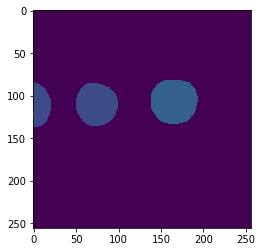

In [47]:
x = sample['image'].float().cuda()
x_rgb = sample['rgb'].float().cuda()
mask = torch.argmax(model(x),dim=1).squeeze().cpu()[0]
mask_rgb = torch.argmax(rgb_model(x_rgb),dim=1).squeeze().cpu()[0]
imshow(mask)

(-0.5, 2065.5, 517.5, -0.5)

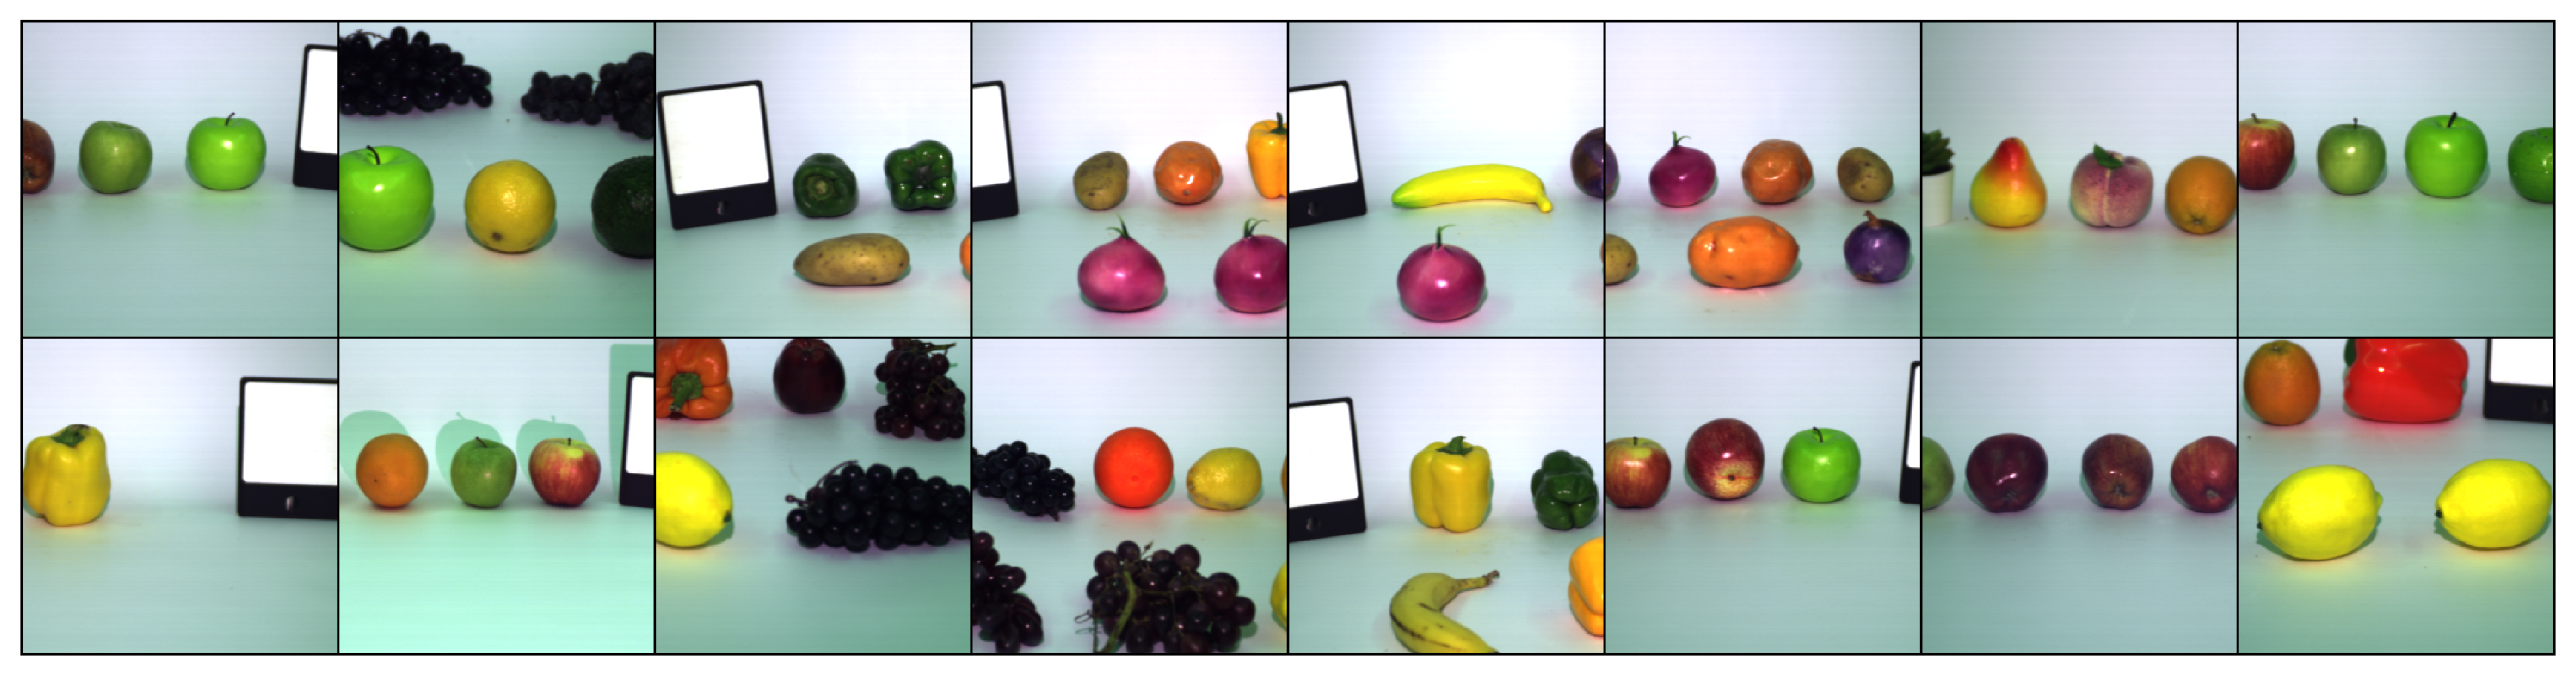

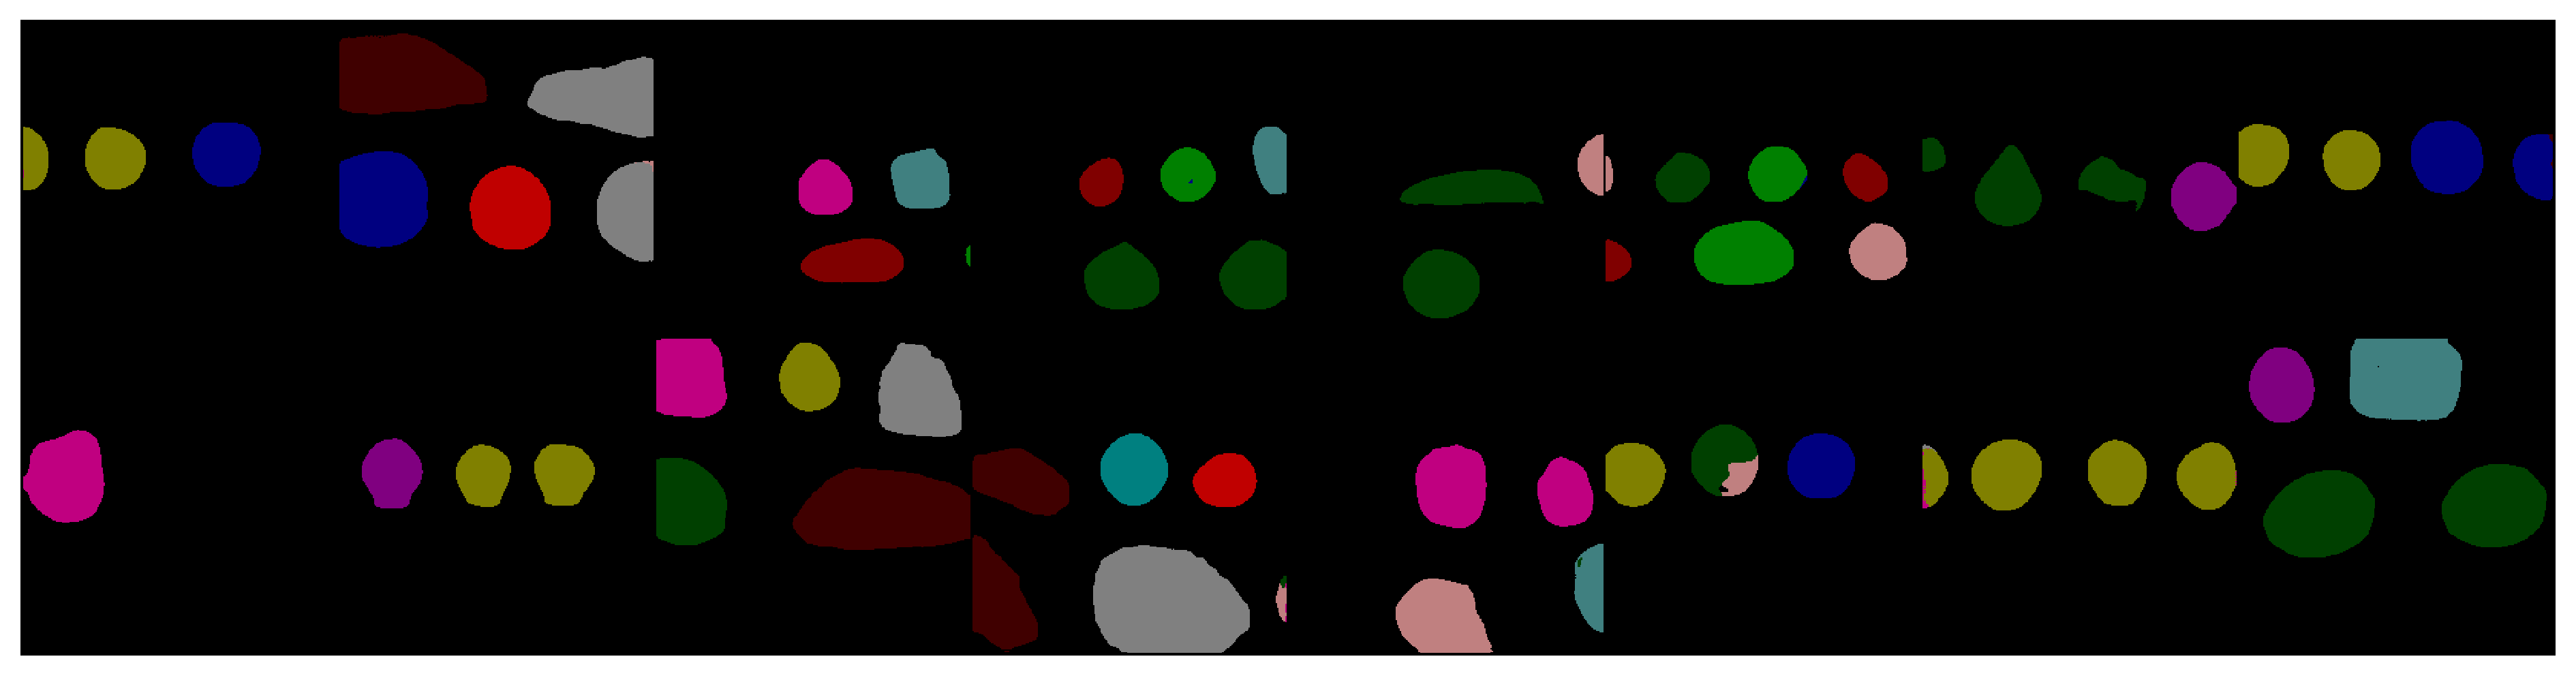

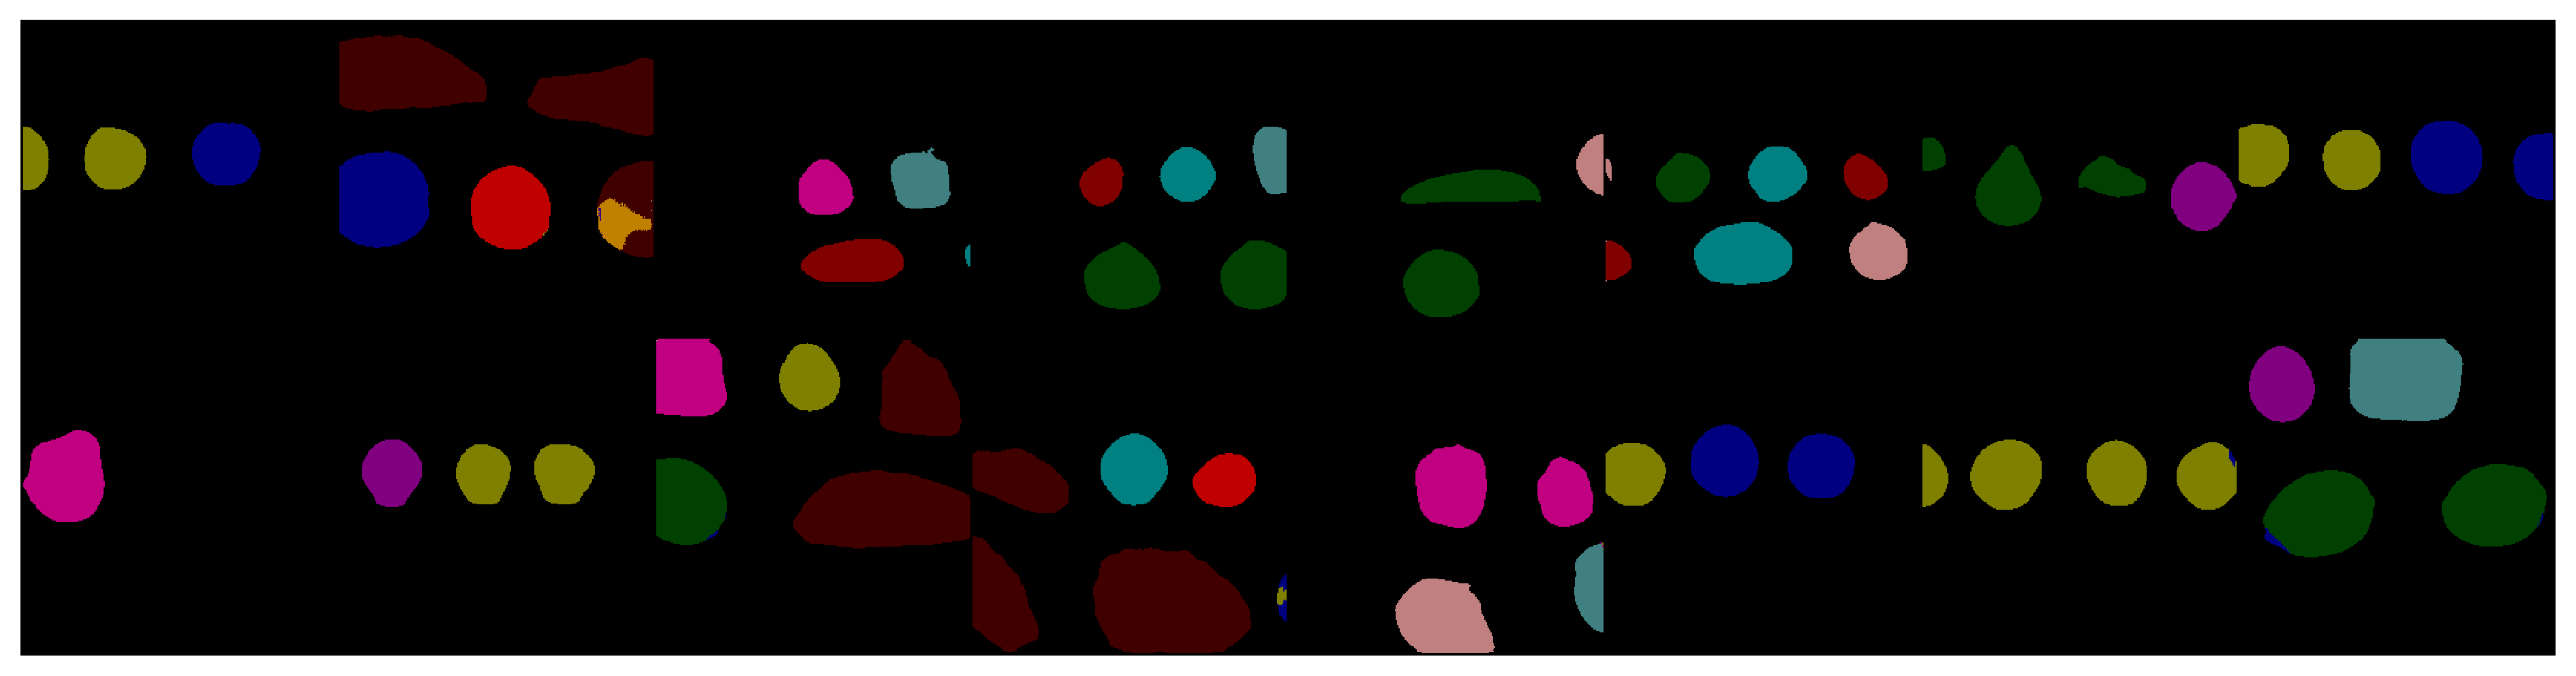

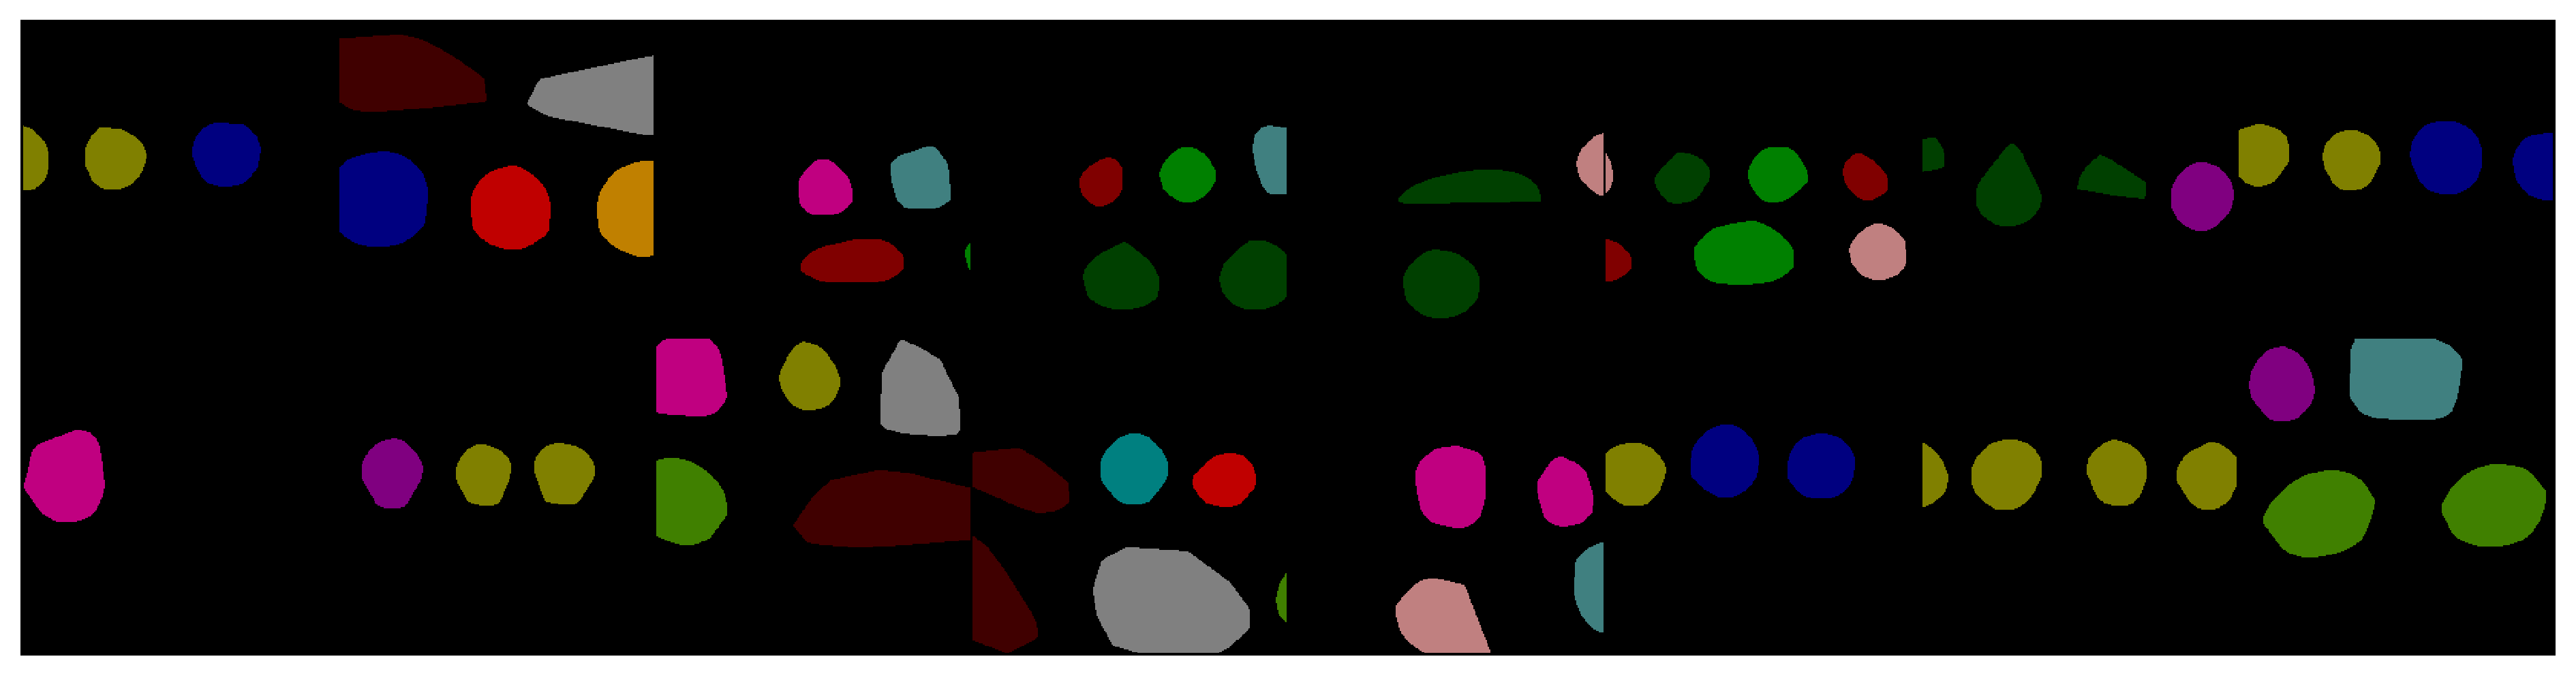

In [48]:
def decode_segmap(mask, unk_label=255, **kargs):
    """Decode segmentation label prediction as RGB images
    Args:
        mask (torch.tensor): class map with dimensions (B, M,N), where the value at
        a given location is the integer denoting the class index.
    Returns:
        (np.ndarray): colored image of shape (BM, BN, 3)
    """
    mask[mask == unk_label] == 0
    mask = mask.numpy()
    cmap = get_labels()
    cmap_exp = cmap[..., None]
    colored = cmap[mask].squeeze()
    grid = make_grid(torch.tensor(colored).permute(0, 3, 1, 2),**kargs)
    return np.transpose(grid, (1, 2, 0))
#%pylab inline
mask = torch.argmax(model(x),dim=1).cpu()
mask_rgb = torch.argmax(rgb_model(x_rgb),dim=1).cpu()
figure(figsize=(16,16), dpi=300); imshow(torchvision.utils.make_grid(sample['rgb'], padding=2).permute((1, 2, 0)))
axis('off')
figure(figsize=(16,16), dpi=300); imshow(decode_segmap(mask, padding=2))
axis('off')
figure(figsize=(16,16), dpi=300); imshow(decode_segmap(mask_rgb, padding=2))
axis('off')
figure(figsize=(16,16), dpi=300); imshow(decode_segmap(sample['label'], padding=2))
axis('off')

In [34]:
torchvision.utils.make_grid?

(-0.5, 1549.5, 259.5, -0.5)

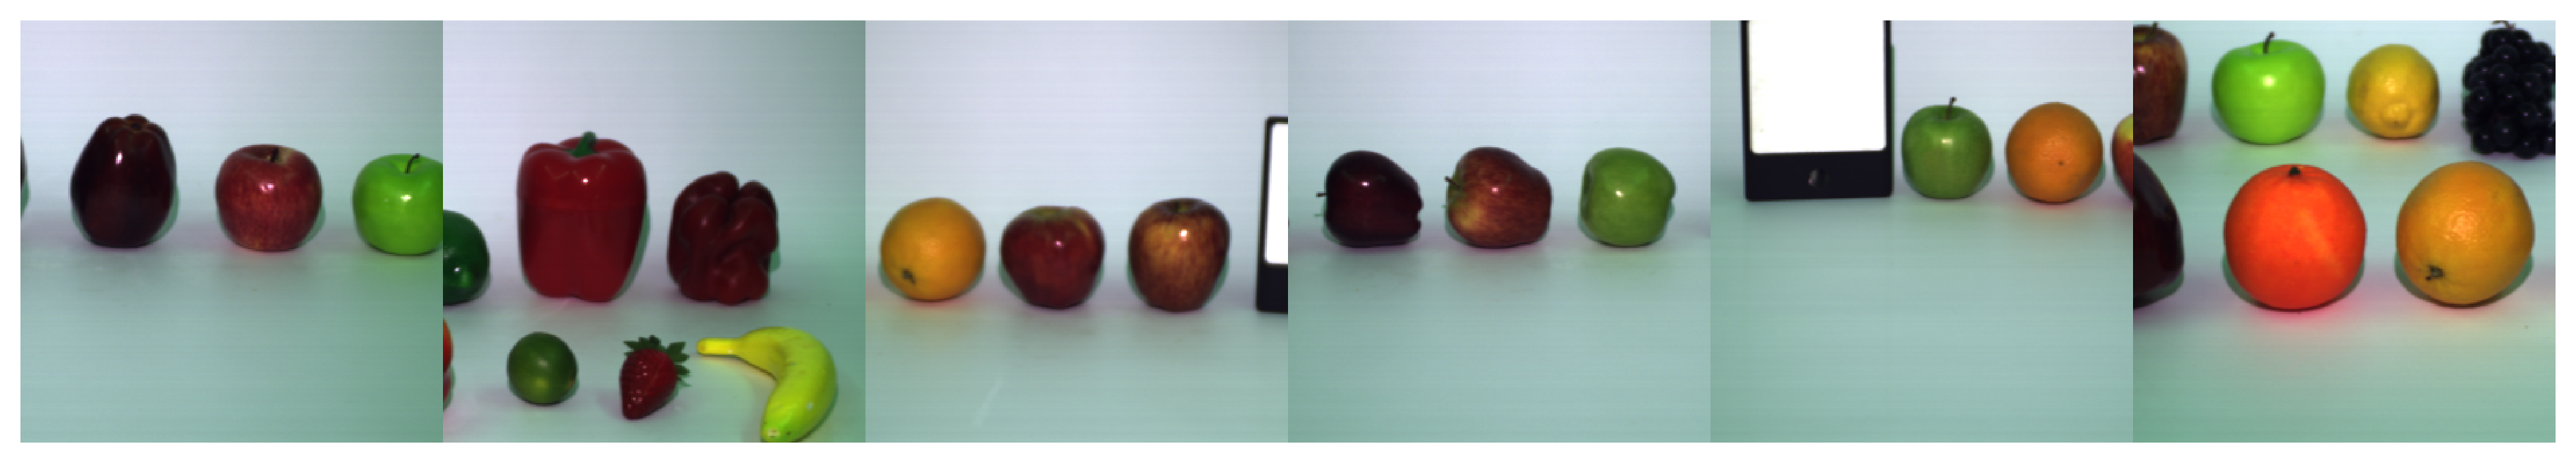

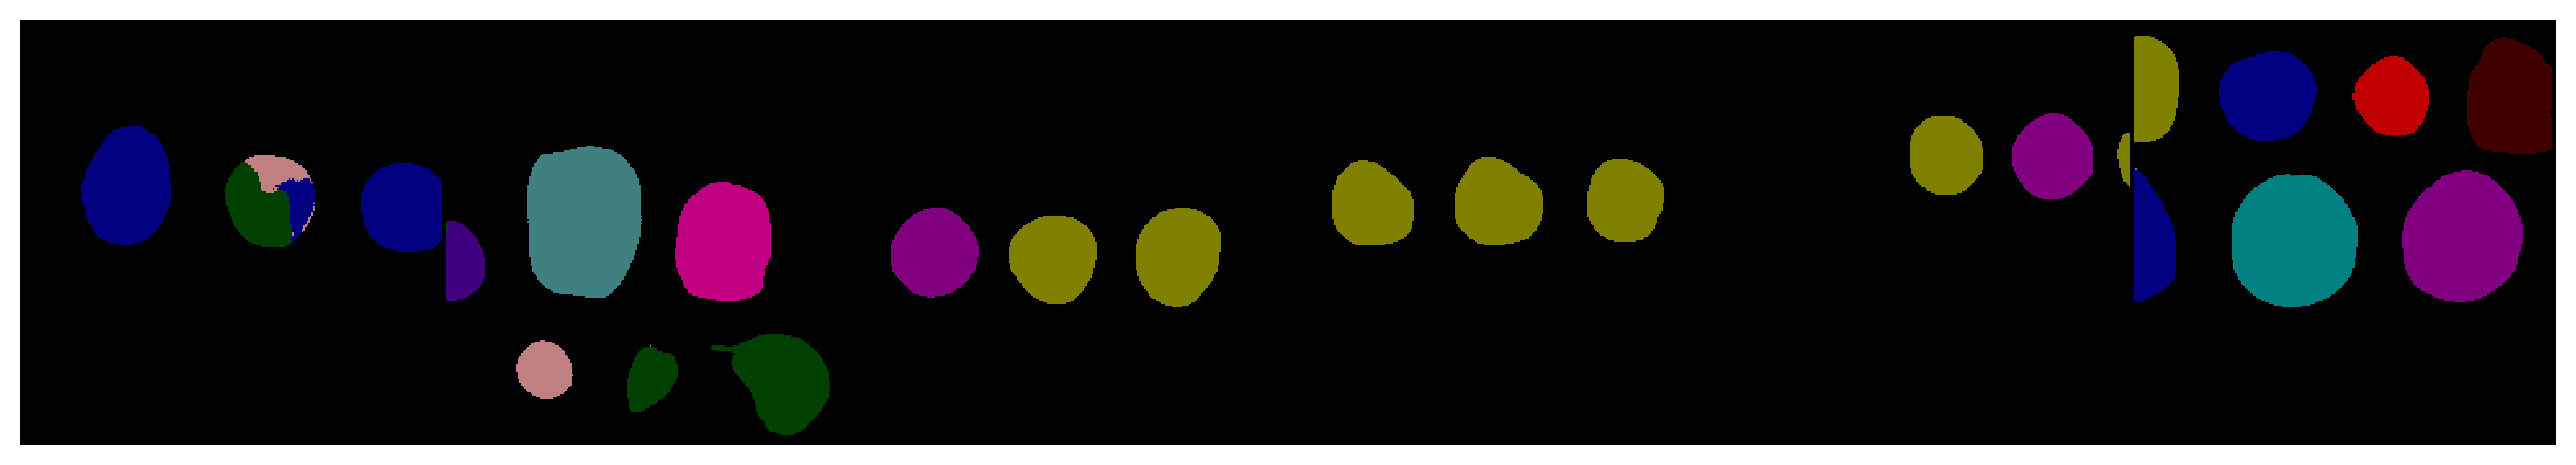

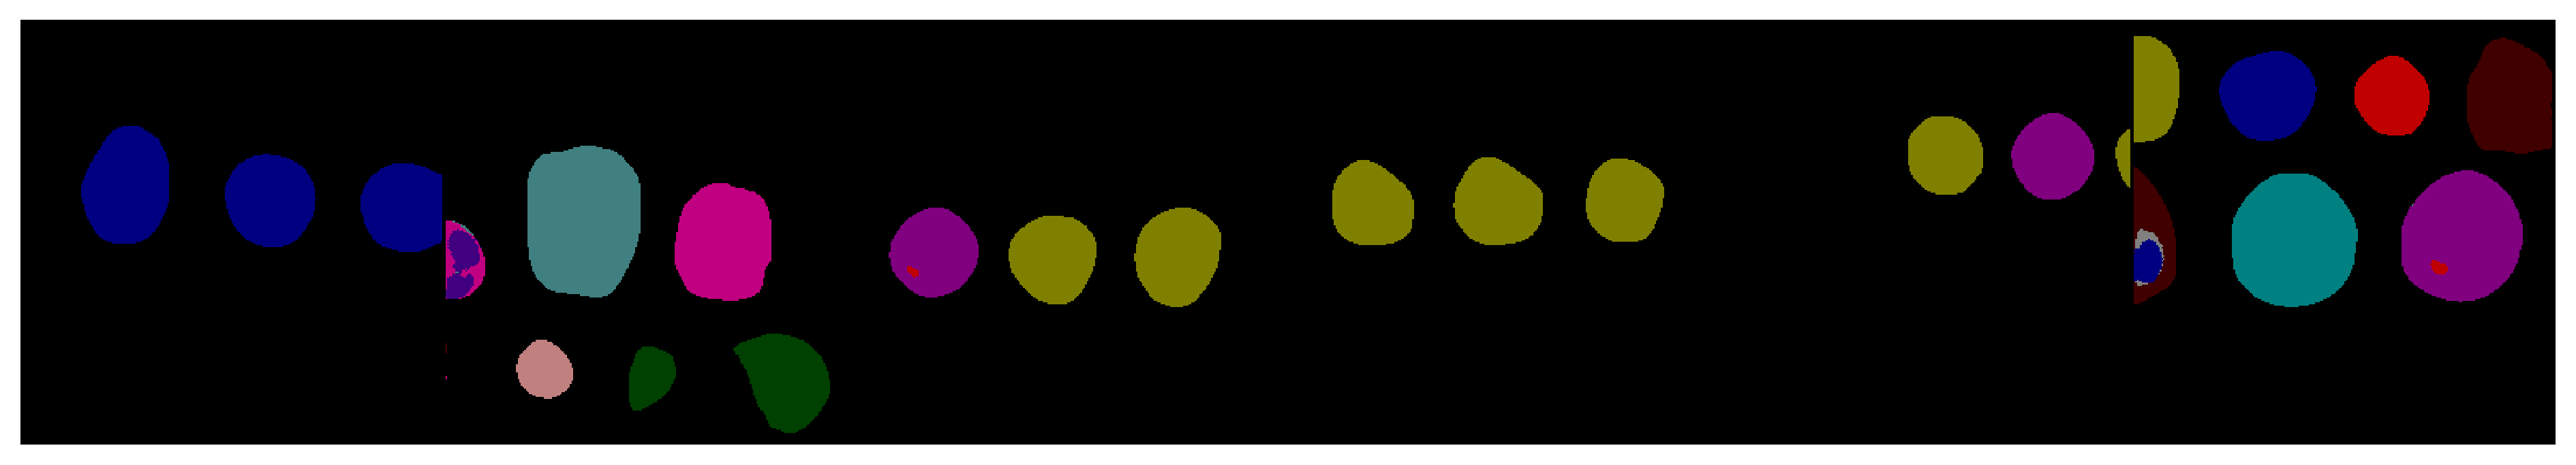

In [217]:
mask = torch.argmax(model(x),dim=1).cpu()
mask_rgb = torch.argmax(rgb_model(x_rgb),dim=1).cpu()
figure(figsize=(16,16),dpi=300); imshow(torchvision.utils.make_grid(sample['rgb'][:6], padding=0).permute((1, 2, 0)))
axis('off')
figure(figsize=(16,16),dpi=300); imshow(decode_segmap(mask[:6]))
axis('off')
figure(figsize=(16,16),dpi=300); imshow(decode_segmap(mask_rgb[:6]))
axis('off')

In [112]:
metrics.reset()
for i, (sample) in enumerate(train_loader):
    if i>= 10:
        break
    x, y = sample['image'].float().cuda(), sample['label'].numpy()
    with torch.no_grad():
        y_pred = model(x)
        y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction

    metrics.add_batch(y, y_pred.detach().cpu().numpy())

In [113]:
print('\nValidation stats ', metrics.get_table())


Validation stats                     IoU        F1      Prec    recall       Acc
bg,           0.994000  0.997000  0.996600  0.997400  0.994800
real potato   0.962600  0.980900  0.987700  0.974300  0.999900
fake potato   0.965500  0.982400  0.987700  0.977200  0.999900
real apple    0.952200  0.975400  0.964500  0.986700  0.999700
fake apple    0.902100  0.948500  0.971400  0.926700  0.998800
real orange   0.978600  0.989100  0.994800  0.983600  0.999900
fake orange   0.954100  0.976400  0.986600  0.966600  0.999600
real grape    0.829400  0.906700  0.853000  0.967700  0.997800
fake grape    0.897100  0.945700  0.933100  0.958800  0.999000
real lemons   0.867300  0.928900  0.988100  0.876400  0.999200
fake lemons   0.000900  0.001800  0.714300  0.000900  0.996800
real avocado  0.036500  0.070400  1.000000  0.036500  0.998100
fake avocado  0.943600  0.970900  0.976400  0.965600  0.999900
real pepper   0.958600  0.978800  0.980800  0.976900  0.999300
fake pepper   0.942600  0.970400  0.

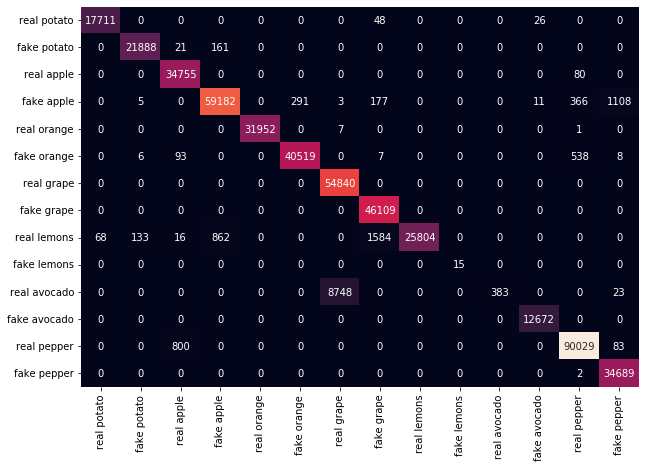

In [156]:
import seaborn as sn
df_cm = pd.DataFrame(metrics.confusion_matrix[1:-2,1:-2], index = [i for i in class_names[1:-2]],
                  columns = [i for i in class_names[1:-2]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.0f',cbar=False)
plt.savefig('confusion_matrix_spectral.pdf',dpi=300)
plt.show()
plt.close()